In [2]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import old_references.nonlinear_QM_FPJPA as Fs
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import standard_sequences.rabi_ef_no_swap as rabi_ef_no_swap
import classifiers.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit

In [3]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]  # offset to sweet spot

Qubit(ro_amp=1, ef_ssm=-0.2568, qubit_thr=[-10000, -600], RO_LO=6.6247, qubit_id=q1, RO_LO_pwr=16, ROIF=0.10275000000000034, ef_amp=1.5, ef_time=49.13671850689116, ge_time=81.17534608287957, RO_IF=None, IQ_angle=205, ge_amp=0.8, ro_freq=6.72745, ge_ssm=-0.1145, ro_dur=4000)
Qubit(ro_amp=1.5, ef_ssm=-0.2962, qubit_thr=[-10000, 1900], RO_LO=6.6247, qubit_id=q2, RO_LO_pwr=16, ROIF=0.030899999999999928, ef_amp=1, ef_time=None, ge_time=45.047198597262124, RO_IF=None, IQ_angle=85, ge_amp=0.8, ro_freq=6.6556, ge_ssm=-0.154, ro_dur=4000)


In [4]:
def run_rabi_ef_swap(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.rabi_ef_swap(
        q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    )
    # rabi_ef_swap.rabi_ef_swap_f(
    #     q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    # )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values


def sweep_J(J_list: list):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.

    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    probs_folder = os.path.join("sweep_J_data", "probs")
    values_folder = os.path.join("sweep_J_data", "values")
    os.makedirs(probs_folder, exist_ok=True)
    os.makedirs(values_folder, exist_ok=True)
    num_steps = 51
    reps = 12000
    sweep_time = 20000
    swap_freq = -0.0195
    swap_time = 0.5 * 6 / abs(swap_freq)

    # Create an array of frequency values
    J_vals = J_list

    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    return_dict = {}
    return_vals = {}
    # Loop over frequencies and populate the dictionary
    for J in J_vals:
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # If both files already exist, load them and skip this iteration
        if os.path.exists(prob_filename) and os.path.exists(values_filename):
            with open(prob_filename, "rb") as f:
                df_prob = pickle.load(f)
            with open(values_filename, "rb") as f:
                values = pickle.load(f)
            return_dict[J] = df_prob
            return_vals[J] = values
            continue  # Skip to the next J value

        a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / 1.5
        # if J is in units of rad/micros
        J_to_a = 1 / a_to_J
        ef_amp = J * J_to_a
        q1.ef_amp = ef_amp
        df_prob, df_pop, values = run_rabi_ef_swap(
            q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time, reps
        )
        # Populate the dictionary at the corresponding frequency key
        return_dict[J] = df_prob
        return_vals[J] = values

        # Create filenames with the current J value
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # Save df_prob to a pickle file
        with open(prob_filename, "wb") as f:
            pickle.dump(df_prob, f)
            del df_prob
        # Save values to a pickle file
        with open(values_filename, "wb") as f:
            pickle.dump(values, f)
            del values
    return return_dict, return_vals

In [5]:
a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / 1.2
# if J is in units of rad/micros
J_to_a = 1 / a_to_J

In [6]:
def sweep_J_curve_fit(probability_dataframes):
    """
    Loops over each J in the probability_dataframes dictionary, performs a
    renormalization and curve fit on the P_f data, and returns a dictionary
    mapping J values to the extracted Rabi angular frequency.

    Parameters:
        probability_dataframes (dict): Dictionary with keys as J values and values as
                                       DataFrames containing columns 'time', 'P_f', 'P_e', etc.
        guess_gamma (float): Initial guess for gamma used in the curve fit for J <= 0.25.
        guess_freq (float): Initial guess for frequency used in the curve fit for J > 0.25.

    Returns:
        omega_values (dict): Dictionary mapping each J value to its extracted angular frequency
                             in rad/µs.
    """
    omega_values = {}

    for J, df in probability_dataframes.items():
        # Extract the time and state probability data from the DataFrame
        times = df["time"].values
        P_f = df["P_f"].values
        P_e = df["P_e"].values

        # Renormalize: P_f_norm = P_f / (P_f + P_e)
        norm_factor = P_f + P_e
        # Avoid division by zero (if that case can ever occur)
        norm_factor[norm_factor == 0] = 1

        guess_gamma = np.sqrt(abs(0.25**2 - J**2))
        guess_freq = np.sqrt(abs(0.25**2 - J**2)) / np.pi
        # Select initial guess values based on J
        if J <= 0.1:
            P_f_norm = P_f / norm_factor
            # P_f_norm = P_f
            guess_vals = [0.0000001, 0.0477, 0.1, -10, 0.5]
        else:
            P_f_norm = P_f / norm_factor
            guess_vals = [guess_freq, 0.2, 0.1, -10, 0.5]
        guess_vals = [guess_freq, guess_gamma, 0.1, -10, 0.5]
        # Perform the curve fit using analysis.fit_sine_decay.
        # It is assumed that this function returns a tuple where the first element
        # is an array of fit parameters, with the first parameter corresponding to frequency.
        fit_vals_f, _, _, _ = analysis.fit_sine_decay(
            times, P_f_norm, guess_vals=guess_vals
        )

        # Calculate the angular frequency: omega = |(freq * 2π)|
        omega_rabi_f = abs(fit_vals_f[0] * 2 * np.pi)

        print(f"J = {J}: Angular freq (rad/µs): {omega_rabi_f}")
        omega_values[J] = omega_rabi_f

    return omega_values

In [7]:
def fit_func(J, J0):
    """
    Model function: Re(sqrt(2*(J^2 - J0^2))).
    Returns sqrt(2*(J^2 - J0^2)) if the argument is non-negative;
    otherwise returns 0.

    Parameters:
        J : array_like
            The independent variable.
        J0 : float
            The parameter to fit.

    Returns:
        array_like : The computed model values.
    """
    expr = 2 * (J**2 - J0**2)
    return np.where(expr >= 0, np.sqrt(expr), 0.0)


def curve_fit_function(J_data, y_data, initial_guess_J0=1.0):
    """
    Fits the data (J_data, y_data) to the function
         f(J) = Re(sqrt(2*(J^2 - J0^2)))
    using the provided initial guess for J0.

    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).

    Returns:
        popt : ndarray
            Optimal value for J0.
        pcov : 2D ndarray
            The estimated covariance of popt.
    """
    popt, pcov = curve_fit(fit_func, J_data, y_data, p0=[initial_guess_J0])
    return popt, pcov


def curve_fit_and_plot(J_data, y_data, initial_guess_J0=1.0):
    """
    Fits the given data to the model function (without offset) and plots the original data
    (scatter plot) along with the fitted curve.

    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).

    Returns:
        popt : ndarray
            The optimal parameter (J0) from the curve fitting.
        pcov : 2D ndarray
            The covariance matrix of the fitted parameter.
    """
    # Perform the curve fit
    popt, pcov = curve_fit_function(J_data, y_data, initial_guess_J0)
    fitted_J0 = popt[0]
    print("Fitted J0 =", fitted_J0)

    # Generate a smooth set of points for plotting the fitted curve
    J_fit = np.linspace(np.min(J_data), np.max(J_data), 1000)
    y_fit = fit_func(J_fit, fitted_J0)

    # Create the plot: scatter for original data and line for fitted curve
    plt.figure(figsize=(8, 5))
    plt.scatter(J_data, y_data, label="Original Data", color="blue", s=30)
    plt.plot(J_fit, y_fit, label="Fitted Curve", color="red", linewidth=2)
    plt.xlabel("J")
    plt.ylabel("Re(sqrt(2*(J^2 - J0^2)))")
    plt.title("Curve Fit: Data and Fitted Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return popt, pcov

In [8]:
def run_rabi_ef_no_swap(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    ef_amp: float,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_no_swap.rabi_ef_no_swap(
        q1,
        q2,
        general_vals_dict,
        ef_amp,
        num_steps,
        sweep_time,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    return values


def run_swap(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    swap_freq: float,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.swap(q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    return values

In [9]:
J_start = 0
J_stop = 1
J_steps = 201
# J_list = np.linspace(10, 10,1)#
J_list = np.linspace(J_start, J_stop, J_steps)
J_dict, vals_dict = sweep_J(J_list)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 88.679480 sec
Captured 200 buffers (2.255313 buffers per sec)
Captured 614400 records (6928.322119 records per sec)
Transferred 10066329600 bytes (113513629.596374 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, N

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

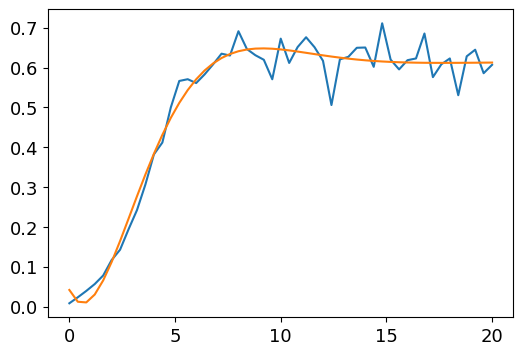



  freq: -0.058687420084071094 +/- 0.0032602621548519332
 gamma: 0.33662723698090385 +/- 0.0476826085462288
   amp: 1.011531351235064 +/- 0.1407842450514349
 phase: -34.45273429548964 +/- 6.390032787743858
offset: 0.6138158355827038 +/- 0.007804516865502116
pi_pulse time: -8.519713411898808 +/- 0.0032602621548519332
J = 0.0: Angular freq (rad/µs): 0.36874393558851165


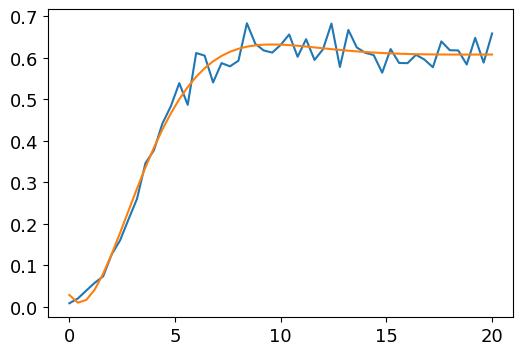



  freq: 0.05491983703048543 +/- 0.00285567604240025
 gamma: 0.3559467737115961 +/- 0.04706880314183316
   amp: 1.0211505430558172 +/- 0.14335110033847562
 phase: -145.3852176589684 +/- 6.224298605201257
offset: 0.6082128499435626 +/- 0.006433017971636768
pi_pulse time: 9.104178508804663 +/- 0.00285567604240025
J = 0.005: Angular freq (rad/µs): 0.34507151310264345


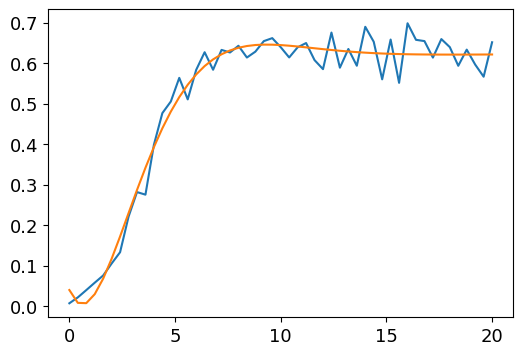



  freq: -0.05726990333830305 +/- 0.0033323700551171442
 gamma: 0.3730521697387812 +/- 0.05422403302451442
   amp: 1.1147720364386227 +/- 0.17870490982543194
 phase: -31.462266298147938 +/- 6.3718924710283344
offset: 0.6219949975628969 +/- 0.00741663479857615
pi_pulse time: -8.730589207500755 +/- 0.0033323700551171442
J = 0.01: Angular freq (rad/µs): 0.35983741519882084


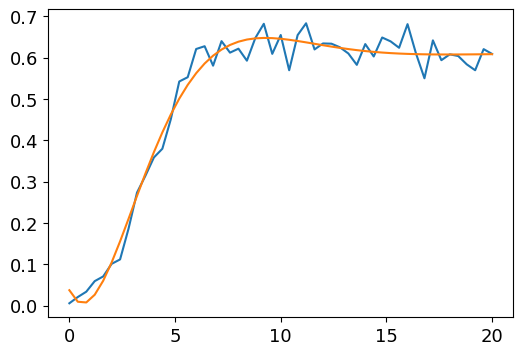



  freq: -0.057909854444726995 +/- 0.002610862757862698
 gamma: 0.32130466871644037 +/- 0.03679034424615396
   amp: 0.985440088022251 +/- 0.10768085911368043
 phase: -35.52210360419496 +/- 5.249818594189057
offset: 0.6099239679237343 +/- 0.006523030871494605
pi_pulse time: -8.634109078571992 +/- 0.002610862757862698
J = 0.015: Angular freq (rad/µs): 0.36385834658801713


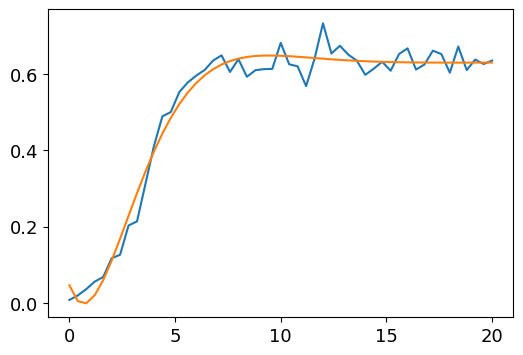



  freq: -0.05689251824960623 +/- 0.003584453279870696
 gamma: 0.40401992139044623 +/- 0.05705211272150156
   amp: 1.2491034716647393 +/- 0.21628156078451455
 phase: -27.851479952016263 +/- 5.871887049300186
offset: 0.6298130595841043 +/- 0.007121532868228169
pi_pulse time: -8.788501816817726 +/- 0.003584453279870696
J = 0.02: Angular freq (rad/µs): 0.35746623475437234


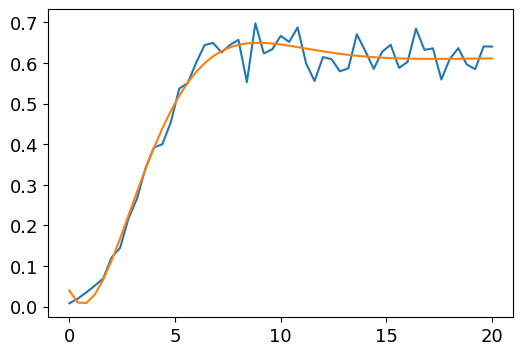



  freq: 0.06012862098793318 +/- 0.002954355106711004
 gamma: 0.33520435888992817 +/- 0.04141824509091521
   amp: 0.9947459919143966 +/- 0.11764046134638283
 phase: -144.8470183913531 +/- 5.622357103471758
offset: 0.6123594615759397 +/- 0.006865011876806291
pi_pulse time: 8.315507520126593 +/- 0.002954355106711004
J = 0.025: Angular freq (rad/µs): 0.37779926793235186


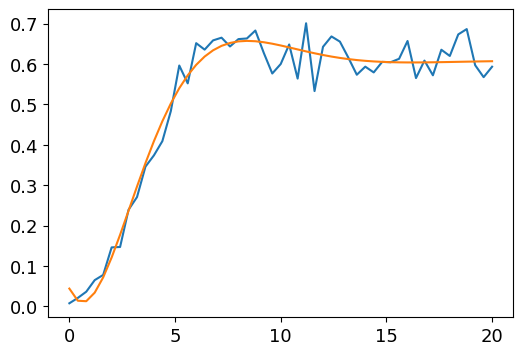



  freq: -0.064087284802995 +/- 0.0034818095534658536
 gamma: 0.31977681634257765 +/- 0.041367465601500245
   amp: -0.9293953551370896 +/- 0.10555050816953862
 phase: -217.36897323658553 +/- 6.063491248235749
offset: 0.6079617050383873 +/- 0.007565194844891298
pi_pulse time: -7.801859628427158 +/- 0.0034818095534658536
J = 0.03: Angular freq (rad/µs): 0.40267228625121176


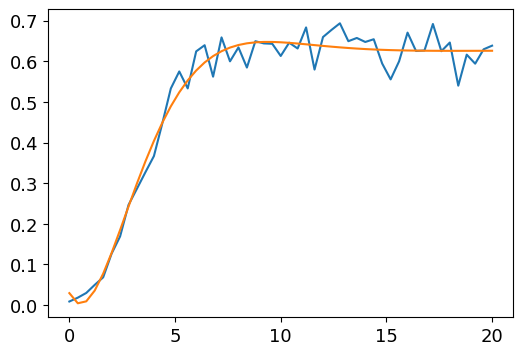



  freq: -0.056472873690777546 +/- 0.003499168700010554
 gamma: 0.3813595828944307 +/- 0.05830749727253424
   amp: 1.1170904291687407 +/- 0.1912177459791213
 phase: -32.31962209909398 +/- 6.939219589457521
offset: 0.6265562311797332 +/- 0.007462403845928476
pi_pulse time: -8.853808338810529 +/- 0.003499168700010554
J = 0.035: Angular freq (rad/µs): 0.3548295302281021


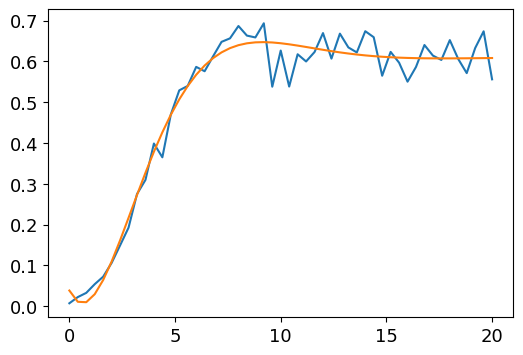



  freq: -0.058614140565681004 +/- 0.003248139839947547
 gamma: 0.32536041993895914 +/- 0.04551535305384521
   amp: 0.9812065567069143 +/- 0.1307032219360659
 phase: -35.62185959151465 +/- 6.427289626591217
offset: 0.6098831333569003 +/- 0.007862237359787172
pi_pulse time: -8.530364775027573 +/- 0.003248139839947547
J = 0.04: Angular freq (rad/µs): 0.36828350679524585


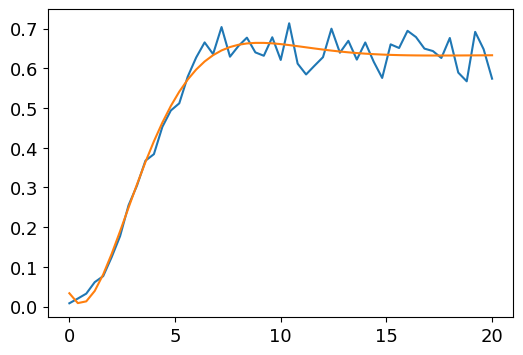



  freq: 0.059124841380919085 +/- 0.00324321480717355
 gamma: 0.35730412853097854 +/- 0.0494399742341584
   amp: 1.049474375234712 +/- 0.14609133982645134
 phase: -145.10903724428408 +/- 6.387084058393067
offset: 0.6338890435113842 +/- 0.0072835190444205345
pi_pulse time: 8.456682306827485 +/- 0.00324321480717355
J = 0.045: Angular freq (rad/µs): 0.3714923346539144


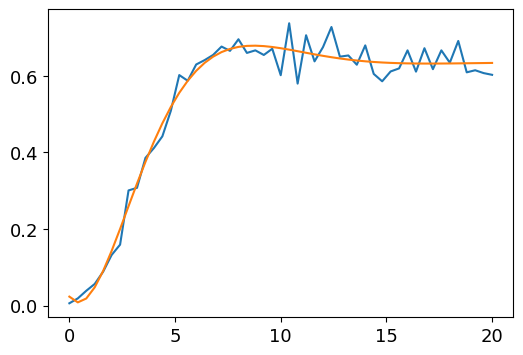



  freq: -0.06027734774861575 +/- 0.0031146994729959855
 gamma: 0.3210856462067863 +/- 0.03840384029588106
   amp: -0.9407201530206962 +/- 0.09850813927589812
 phase: -220.547621556283 +/- 6.03646942195932
offset: 0.6352329892002696 +/- 0.006800020035380213
pi_pulse time: -8.294990053066533 +/- 0.0031146994729959855
J = 0.05: Angular freq (rad/µs): 0.37873374572985696


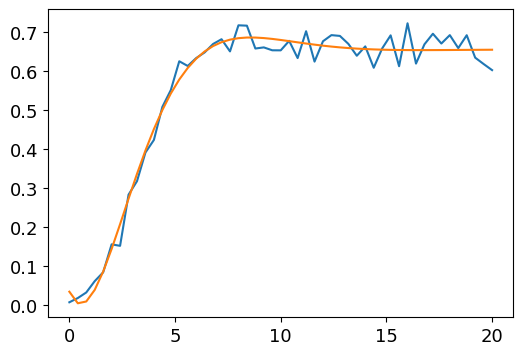



  freq: 0.06216335143971427 +/- 0.0028179954372344112
 gamma: 0.37906931299924557 +/- 0.04307934270807861
   amp: 1.112761072201232 +/- 0.1288199167299748
 phase: -146.09214303094572 +/- 5.135308743017739
offset: 0.6559247017045755 +/- 0.006027696596876258
pi_pulse time: 8.043324377143625 +/- 0.0028179954372344112
J = 0.055: Angular freq (rad/µs): 0.3905838564110537


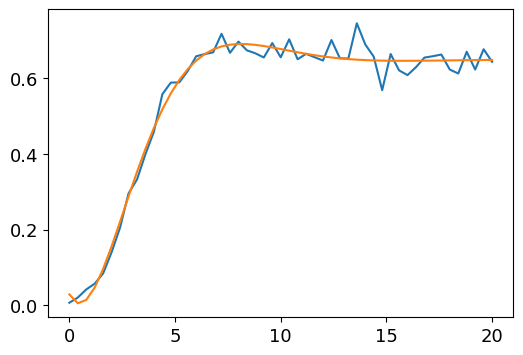



  freq: 0.06534802755679467 +/- 0.0027242469325780847
 gamma: 0.3573426132855419 +/- 0.03536847168089511
   amp: 1.0095971847729375 +/- 0.09096214981267932
 phase: -142.1604453834647 +/- 4.736301794392419
offset: 0.6482431587989543 +/- 0.005456819106799381
pi_pulse time: 7.651340349415208 +/- 0.0027242469325780847
J = 0.06: Angular freq (rad/µs): 0.410593766598019


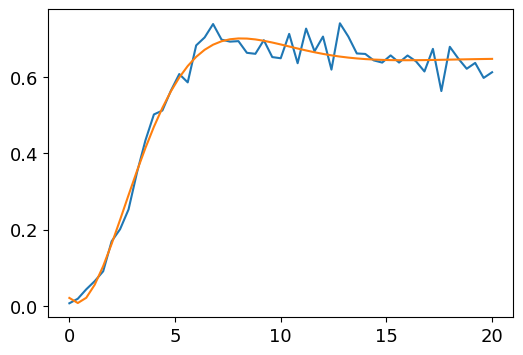



  freq: -0.06444884035053042 +/- 0.003233114929891975
 gamma: 0.32155036149480215 +/- 0.03490689538945162
   amp: -0.9256466152191757 +/- 0.08256092098075778
 phase: -222.74086354847543 +/- 5.663936409130069
offset: 0.6489566149555694 +/- 0.006443177713566138
pi_pulse time: -7.758091492113015 +/- 0.003233114929891975
J = 0.065: Angular freq (rad/µs): 0.4049440067552156


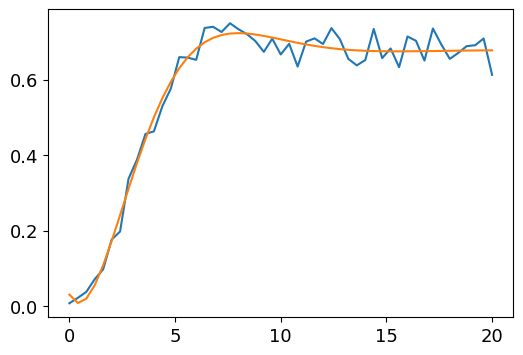



  freq: 0.06632267677381058 +/- 0.0029326568875044797
 gamma: 0.3574649941102784 +/- 0.03689216183513903
   amp: 1.0361918128467897 +/- 0.09555001453004655
 phase: -141.32348603671704 +/- 5.007653463532092
offset: 0.67793965890377 +/- 0.005920456674978613
pi_pulse time: 7.538899578875855 +/- 0.0029326568875044797
J = 0.07: Angular freq (rad/µs): 0.41671766823802747


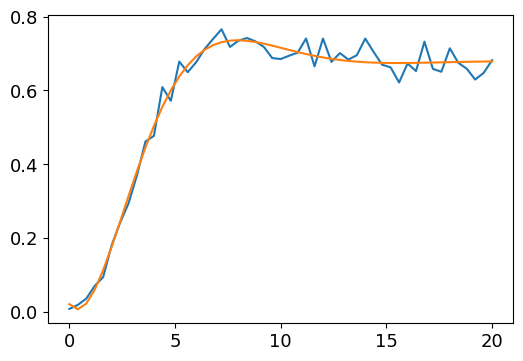



  freq: -0.0659841965896211 +/- 0.002641865780741772
 gamma: 0.32595429962025596 +/- 0.027952573545680332
   amp: -0.9653167113888969 +/- 0.06738695823173374
 phase: -222.97861693053324 +/- 4.485770342098613
offset: 0.6791995453221625 +/- 0.005308659178657729
pi_pulse time: -7.577571992119199 +/- 0.002641865780741772
J = 0.075: Angular freq (rad/µs): 0.41459093451795664


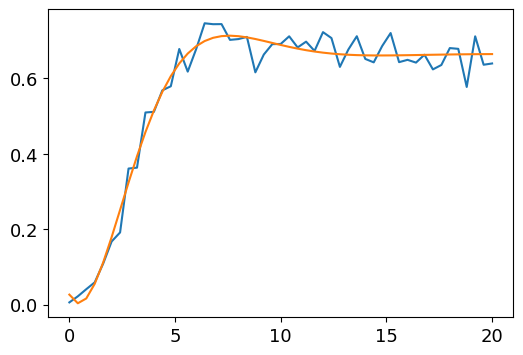



  freq: 0.0701222159991805 +/- 0.0035705264871192573
 gamma: 0.3653385394171487 +/- 0.04249746238129102
   amp: 1.0071803095059124 +/- 0.1017978324448528
 phase: -140.7375552967506 +/- 5.665597459924078
offset: 0.6642028327419475 +/- 0.006583893825215871
pi_pulse time: 7.130407858271954 +/- 0.0035705264871192573
J = 0.08: Angular freq (rad/µs): 0.44059087727292423


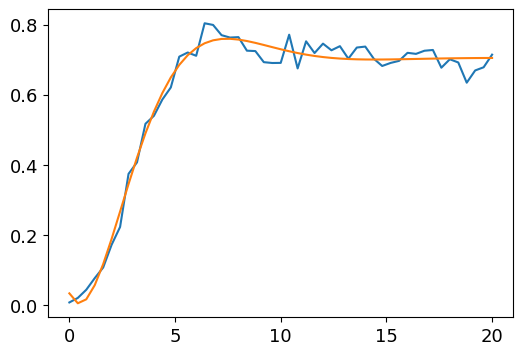



  freq: 0.07161585281653811 +/- 0.0028601951986299925
 gamma: 0.3643320230459826 +/- 0.033273914304037984
   amp: 1.06824908874772 +/- 0.08406097978931663
 phase: -141.08882979819424 +/- 4.39856480774494
offset: 0.7046780558889574 +/- 0.00559080218399755
pi_pulse time: 6.98169442010102 +/- 0.0028601951986299925
J = 0.085: Angular freq (rad/µs): 0.44997567417800804


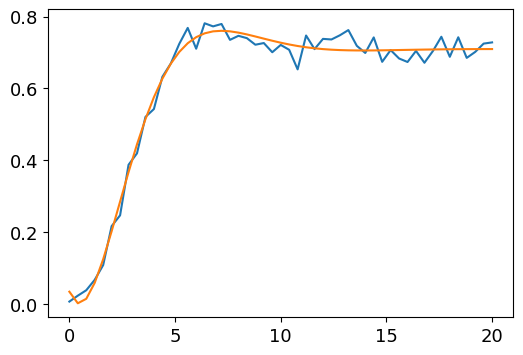



  freq: 0.07449507728566325 +/- 0.0027134559070249213
 gamma: 0.39176163829983196 +/- 0.033433944652095954
   amp: 1.1096588299153256 +/- 0.08409410766430879
 phase: -142.54261680460706 +/- 3.992163482732826
offset: 0.709272696785948 +/- 0.005016332017689591
pi_pulse time: 6.71185289308004 +/- 0.0027134559070249213
J = 0.09: Angular freq (rad/µs): 0.4680663750584871


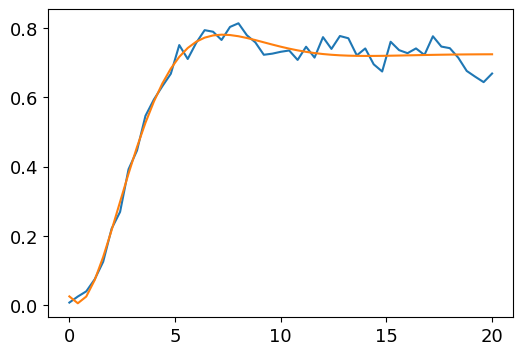



  freq: 0.07280361739422832 +/- 0.0031022563210071344
 gamma: 0.36918194849102787 +/- 0.0345886621203243
   amp: 1.0635603179886643 +/- 0.08339692102935269
 phase: -138.92582879223647 +/- 4.704376059537205
offset: 0.7244291051650059 +/- 0.005726275697749103
pi_pulse time: 6.867790611179696 +/- 0.0031022563210071344
J = 0.095: Angular freq (rad/µs): 0.4574386191209395


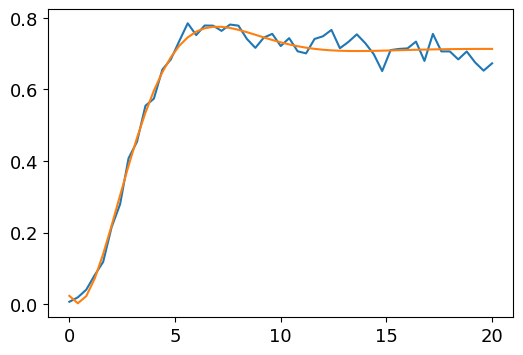



  freq: 0.07564733495697326 +/- 0.002694912273193086
 gamma: 0.36738490450024475 +/- 0.02819731316160546
   amp: 1.0343614454054428 +/- 0.06444564571563047
 phase: -138.17079643357823 +/- 3.8853589873868706
offset: 0.7128320011671514 +/- 0.004754218977310593
pi_pulse time: 6.6096181747101905 +/- 0.002694912273193086
J = 0.1: Angular freq (rad/µs): 0.4753062235289471


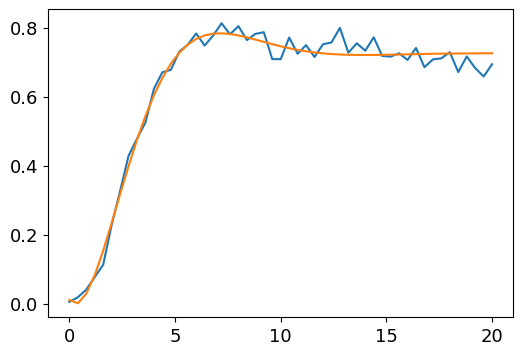



  freq: -0.07317474936436195 +/- 0.0030300855743487965
 gamma: 0.3691674263814604 +/- 0.031997650342565714
   amp: -1.0349517597982305 +/- 0.07242574525283885
 phase: -223.66316199596514 +/- 4.5723394193482445
offset: 0.725543236546686 +/- 0.005240047442803289
pi_pulse time: -6.832958149406567 +/- 0.0030300855743487965
J = 0.105: Angular freq (rad/µs): 0.4597705100627078


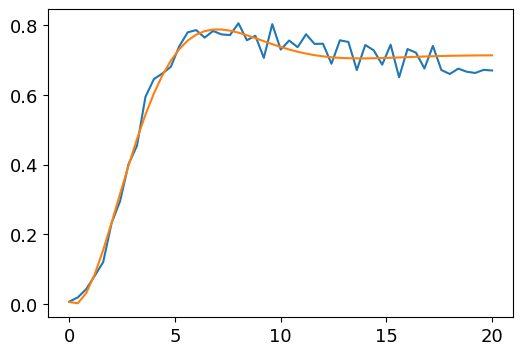



  freq: -0.07377966811647241 +/- 0.0034914810348886825
 gamma: 0.3316581208458202 +/- 0.029887208709787644
   amp: -0.9474990309656992 +/- 0.06198760757140699
 phase: -228.21455330688858 +/- 5.131203087767084
offset: 0.7128471351444192 +/- 0.00601354422763504
pi_pulse time: -6.7769347947008125 +/- 0.0034914810348886825
J = 0.11: Angular freq (rad/µs): 0.4635713266780056


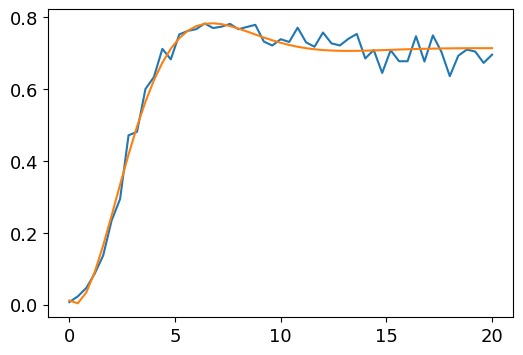



  freq: -0.07732435306890062 +/- 0.0032826740422690504
 gamma: 0.3585290570213452 +/- 0.030129757601032845
   amp: -0.9743578565073946 +/- 0.06166024715279583
 phase: -226.12600082256597 +/- 4.594615252065427
offset: 0.7136590058908149 +/- 0.005289817588735368
pi_pulse time: -6.466268131004861 +/- 0.0032826740422690504
J = 0.115: Angular freq (rad/µs): 0.48584323908968313


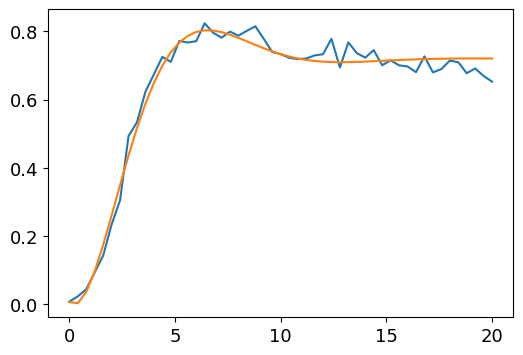



  freq: -0.07917049764489932 +/- 0.003350034769196594
 gamma: 0.34025010815638734 +/- 0.026979422634892423
   amp: -0.9429968835141761 +/- 0.052634907159318886
 phase: -229.09275351813488 +/- 4.55408255547824
offset: 0.7193724430842394 +/- 0.005396461104262077
pi_pulse time: -6.315483859184928 +/- 0.003350034769196594
J = 0.12: Angular freq (rad/µs): 0.49744290756452747


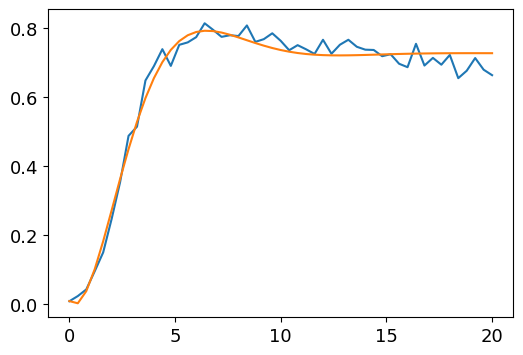



  freq: -0.07998037563758291 +/- 0.003639620758156348
 gamma: 0.3847800889478187 +/- 0.03514748847520735
   amp: -1.010182229175439 +/- 0.070995269070005
 phase: -225.41474390230553 +/- 4.9254181851444665
offset: 0.727463235802477 +/- 0.005511894299412011
pi_pulse time: -6.251533529495568 +/- 0.003639620758156348
J = 0.125: Angular freq (rad/µs): 0.5025315210687651


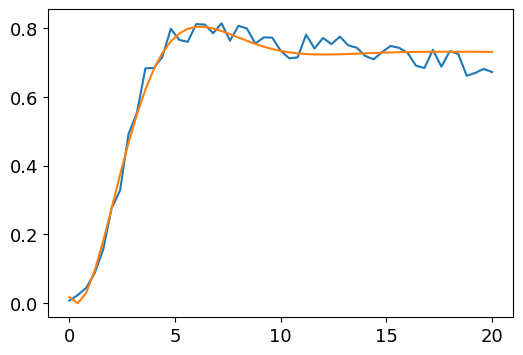



  freq: 0.08540742567607137 +/- 0.0037306172547279482
 gamma: 0.39192885064751787 +/- 0.035407164820173746
   amp: -1.0328763550886926 +/- 0.0718354912829707
 phase: -316.2814783131461 +/- 4.678838382213306
offset: 0.730927781726595 +/- 0.005666555556167666
pi_pulse time: 5.854291896074385 +/- 0.0037306172547279482
J = 0.13: Angular freq (rad/µs): 0.5366306821319242


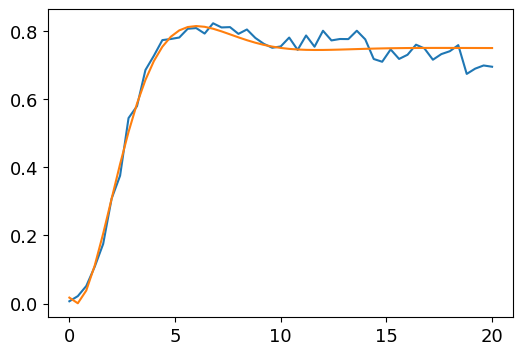



  freq: 0.08769517541421336 +/- 0.0037131370204888815
 gamma: 0.4299834064482386 +/- 0.03860835235753966
   amp: 1.0837148112856982 +/- 0.07799287840894835
 phase: -497.5260683966753 +/- 4.54859028488515
offset: 0.7496117737363612 +/- 0.005254912070933137
pi_pulse time: 5.701567932766363 +/- 0.0037131370204888815
J = 0.135: Angular freq (rad/µs): 0.5510050376731218


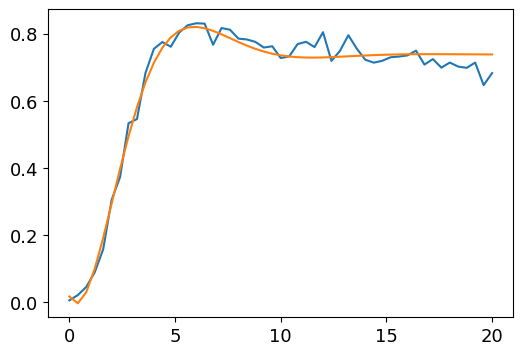



  freq: 0.08965063457879381 +/- 0.0037662056988889566
 gamma: 0.3938198386544545 +/- 0.03383416521554799
   amp: 1.0304718510733022 +/- 0.06641633962829079
 phase: -495.66717136668103 +/- 4.476654668701867
offset: 0.7377655483051113 +/- 0.005563905054741281
pi_pulse time: 5.577205363343532 +/- 0.0037662056988889566
J = 0.14: Angular freq (rad/µs): 0.5632915499648035


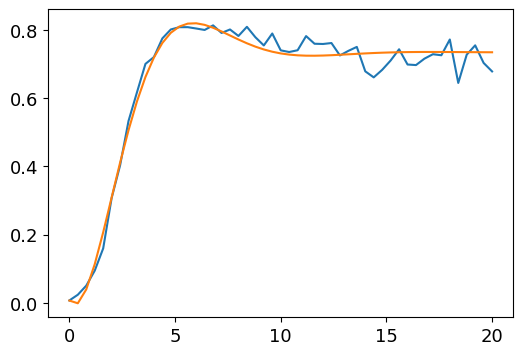



  freq: 0.08918690687061287 +/- 0.003996965092835683
 gamma: 0.3845376553567411 +/- 0.03327725032352953
   amp: 0.9868331391178404 +/- 0.061182417239066623
 phase: -492.55796582582013 +/- 4.776302594879999
offset: 0.7340567749469373 +/- 0.005636388853867816
pi_pulse time: 5.60620406676252 +/- 0.003996965092835683
J = 0.145: Angular freq (rad/µs): 0.5603778628422289


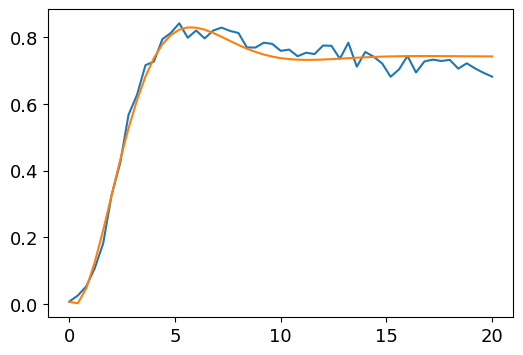



  freq: -0.09050706035916818 +/- 0.0036985925466653004
 gamma: 0.38757196133419036 +/- 0.03004842616295677
   amp: 0.984029963570541 +/- 0.0538142073103411
 phase: -1128.3809383426092 +/- 4.347115931227438
offset: 0.7423327897807721 +/- 0.00507133368679219
pi_pulse time: -5.524430889875333 +/- 0.0036985925466653004
J = 0.15: Angular freq (rad/µs): 0.5686726318447415


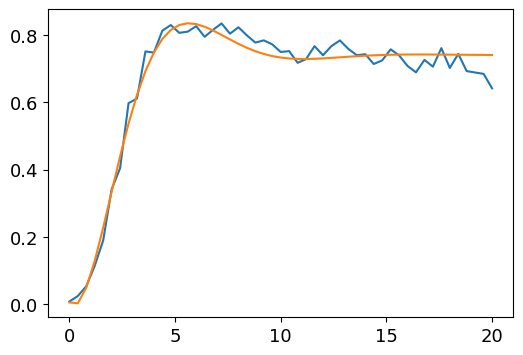



  freq: 0.09191157844144046 +/- 0.0043233447920845505
 gamma: 0.3796232725593101 +/- 0.033248902079244344
   amp: 0.9658302700992158 +/- 0.05801440798427726
 phase: -850.3753172631217 +/- 5.010385826685435
offset: 0.7410689631584421 +/- 0.005901806079736815
pi_pulse time: 5.440011024493117 +/- 0.0043233447920845505
J = 0.155: Angular freq (rad/µs): 0.5774974792229427


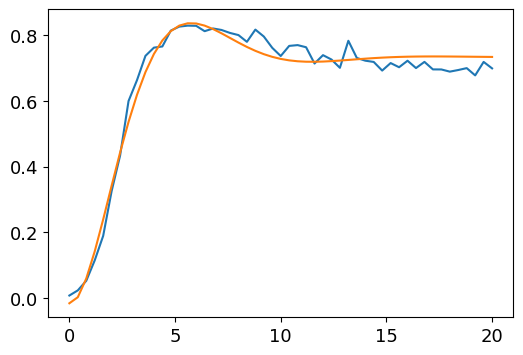



  freq: 0.08743402843135573 +/- 0.004168787029794485
 gamma: 0.34620526755438485 +/- 0.02724497130176132
   amp: 0.8970470835487337 +/- 0.04337179904755557
 phase: -483.49304318566175 +/- 5.078899550993143
offset: 0.7327958885366169 +/- 0.005684245994777059
pi_pulse time: 5.718597312401647 +/- 0.004168787029794485
J = 0.16: Angular freq (rad/µs): 0.5493642027874165


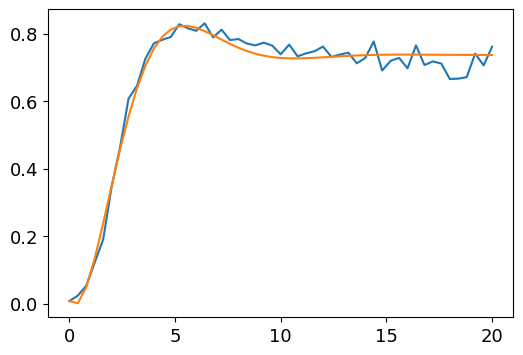



  freq: 0.09604116252935921 +/- 0.004025410043798763
 gamma: 0.4118920532391155 +/- 0.033272498200334344
   amp: 0.9883631962643512 +/- 0.05686472393363989
 phase: -492.50219588158325 +/- 4.434180662826715
offset: 0.7367188371362144 +/- 0.005078424825956815
pi_pulse time: 5.2061010803274375 +/- 0.004025410043798763
J = 0.165: Angular freq (rad/µs): 0.6034444212889164


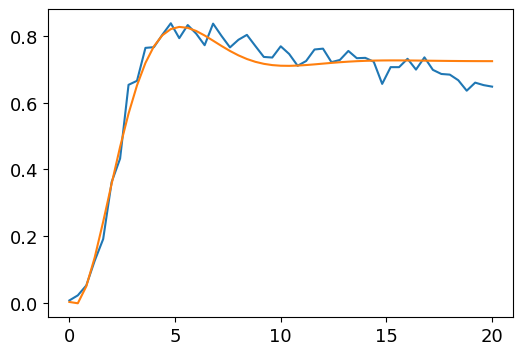



  freq: 0.0991679807045922 +/- 0.0054189166088395285
 gamma: 0.3899871027155645 +/- 0.03964683086318827
   amp: 0.9418779967408988 +/- 0.06420527416142725
 phase: -489.8832550066298 +/- 5.826250583639645
offset: 0.7252370896322798 +/- 0.006834516902719812
pi_pulse time: 5.041949996838509 +/- 0.0054189166088395285
J = 0.17: Angular freq (rad/µs): 0.6230907993057625


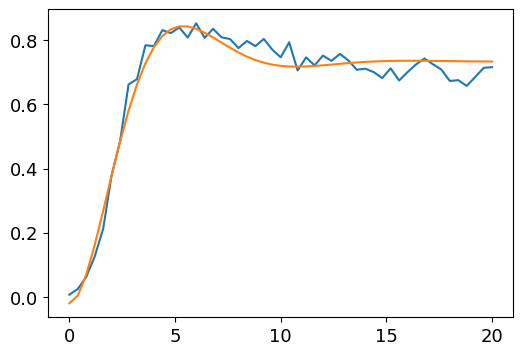



  freq: 0.09310090352380473 +/- 0.0051513968728441216
 gamma: 0.35771850790176407 +/- 0.031997762010283065
   amp: 0.886444030003639 +/- 0.047178971202742566
 phase: -481.9128963361484 +/- 5.8875639354164475
offset: 0.7330548415176524 +/- 0.006483358635607595
pi_pulse time: 5.3705171601493245 +/- 0.0051513968728441216
J = 0.17500000000000002: Angular freq (rad/µs): 0.5849702291059141


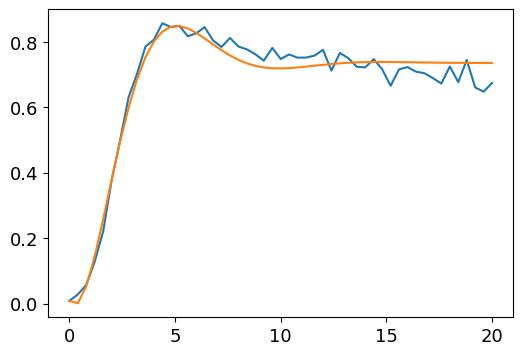



  freq: 0.10333040821049952 +/- 0.004828794199886953
 gamma: 0.38881317539216315 +/- 0.03409388840900223
   amp: 0.946120838358675 +/- 0.054896016599942206
 phase: -489.7639496820183 +/- 5.016703255575995
offset: 0.7359067358097503 +/- 0.006117704282006673
pi_pulse time: 4.838846653750028 +/- 0.004828794199886953
J = 0.18: Angular freq (rad/µs): 0.6492441026530794


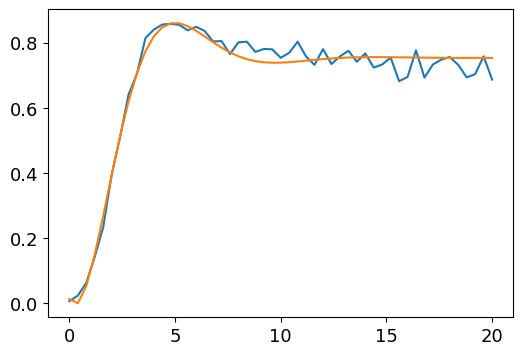



  freq: 0.10572298035264585 +/- 0.00425100856238021
 gamma: 0.4132731599002637 +/- 0.03211952523364095
   amp: 0.9944141698938969 +/- 0.05300690461497596
 phase: -491.9222280685268 +/- 4.270776064333436
offset: 0.7536689531066098 +/- 0.005272918210533877
pi_pulse time: 4.7293407576311 +/- 0.00425100856238021
J = 0.185: Angular freq (rad/µs): 0.6642770767829805


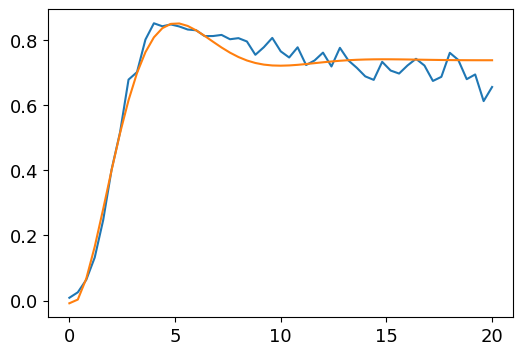



  freq: -0.1016195969256784 +/- 0.005913916117373985
 gamma: 0.38416136952706814 +/- 0.038816676323585694
   amp: 0.9178038063882823 +/- 0.05800841076630848
 phase: -414.4212613855312 +/- 6.216451997030308
offset: 0.7382038849957057 +/- 0.0071108593474938355
pi_pulse time: -4.920310797588435 +/- 0.005913916117373985
J = 0.19: Angular freq (rad/µs): 0.6384947583249344


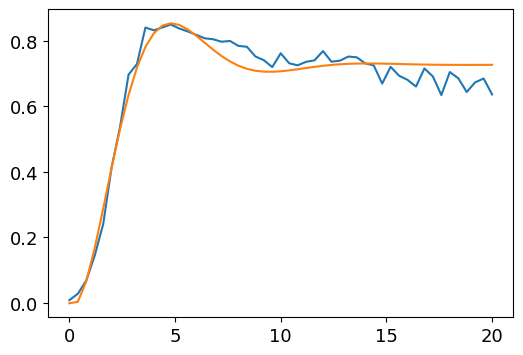



  freq: -0.10763482341496286 +/- 0.005630730029951328
 gamma: 0.37889410123943423 +/- 0.0354547154326219
   amp: 0.8987723115298552 +/- 0.05211006503868995
 phase: -414.17744612450105 +/- 5.694225106596889
offset: 0.7274831137616723 +/- 0.006784676467606099
pi_pulse time: -4.645336742666988 +/- 0.005630730029951328
J = 0.195: Angular freq (rad/µs): 0.676289541021764


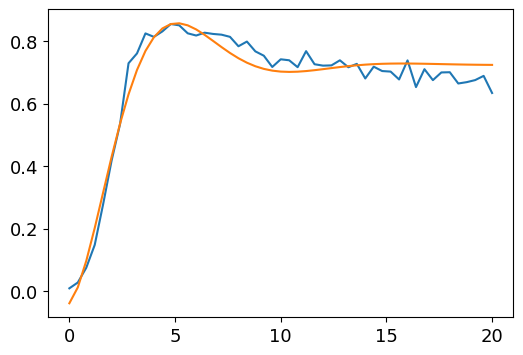



  freq: -0.09401666279937074 +/- 0.0057104916725106356
 gamma: 0.3305844210162735 +/- 0.028301250859029847
   amp: 0.8223351543995413 +/- 0.036005920801334954
 phase: -428.33002730522264 +/- 6.4959260438554685
offset: 0.7246601045872034 +/- 0.007035470720462209
pi_pulse time: -5.318206210605324 +/- 0.0057104916725106356
J = 0.2: Angular freq (rad/µs): 0.5907241143310638


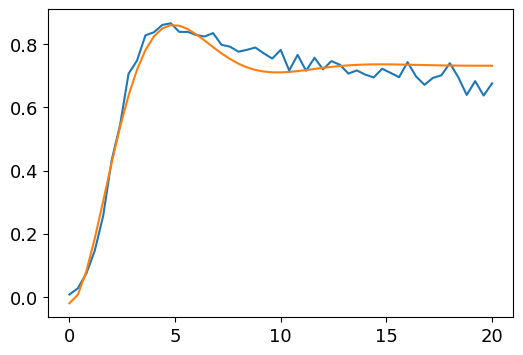



  freq: -0.10181205177667615 +/- 0.005682559819619487
 gamma: 0.3600939595468328 +/- 0.03247565019423717
   amp: 0.8687822034235574 +/- 0.04488412103397691
 phase: -419.9326886396561 +/- 6.0389088974206055
offset: 0.7319938722032524 +/- 0.006838219065806327
pi_pulse time: -4.911009956824617 +/- 0.005682559819619487
J = 0.20500000000000002: Angular freq (rad/µs): 0.6397039878170189


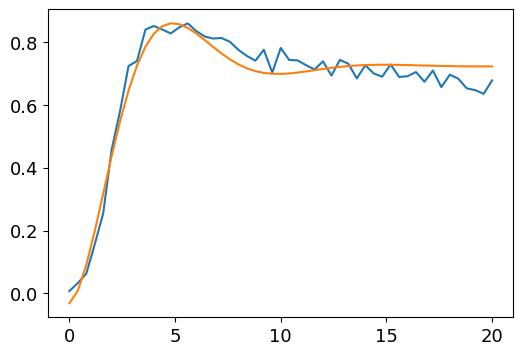



  freq: 0.10042694424049346 +/- 0.005896836877887459
 gamma: 0.34347334307005306 +/- 0.030640994854291084
   amp: 0.8359497703434245 +/- 0.04004756055588765
 phase: -115.33881636859834 +/- 6.385953081219409
offset: 0.7237276230718274 +/- 0.007130013675811843
pi_pulse time: 4.978743541201898 +/- 0.005896836877887459
J = 0.21: Angular freq (rad/µs): 0.6310011004968121


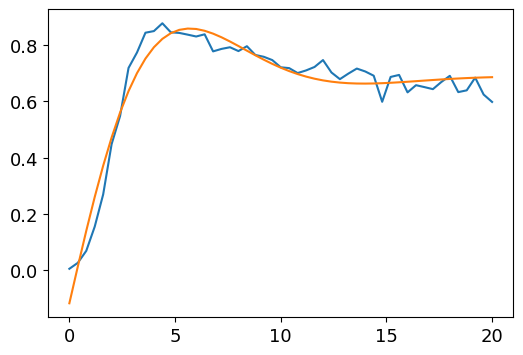



  freq: 0.060607089703148036 +/- 0.005684636362316175
 gamma: 0.25091667922878214 +/- 0.01851246113236026
   amp: 0.8672470227862917 +/- 0.07190528155254662
 phase: -67.5804253120463 +/- 7.643471648719478
offset: 0.6852320365496551 +/- 0.009732702014701262
pi_pulse time: 8.249859916537606 +/- 0.005684636362316175
J = 0.215: Angular freq (rad/µs): 0.38080557553373495


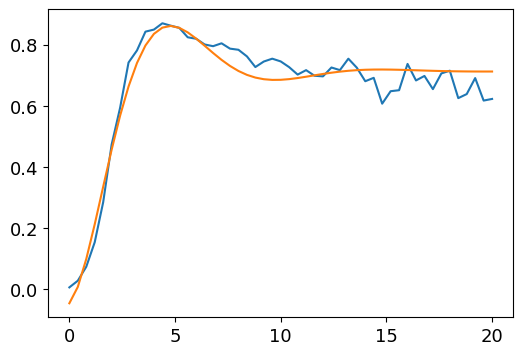



  freq: 0.10055087916982738 +/- 0.0066773450846719555
 gamma: 0.33061987927316183 +/- 0.031678413294388065
   amp: 0.8093214662587009 +/- 0.039742739549612695
 phase: -110.33015268768688 +/- 7.267895269572485
offset: 0.7135711001369621 +/- 0.008096130296887398
pi_pulse time: 4.972606944147302 +/- 0.0066773450846719555
J = 0.22: Angular freq (rad/µs): 0.6317798066238494


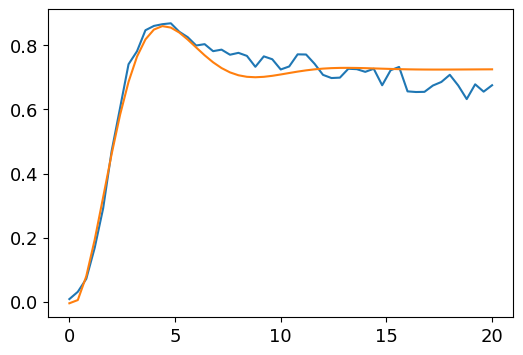



  freq: 0.11577107447640998 +/- 0.0061471001796172715
 gamma: 0.3925298603896626 +/- 0.03695844780552149
   amp: 0.8845336205893022 +/- 0.05024008209073676
 phase: -124.33480821662094 +/- 5.816890534714717
offset: 0.7253209807407494 +/- 0.006819676033801997
pi_pulse time: 4.318868096036218 +/- 0.0061471001796172715
J = 0.225: Angular freq (rad/µs): 0.7274111141465728


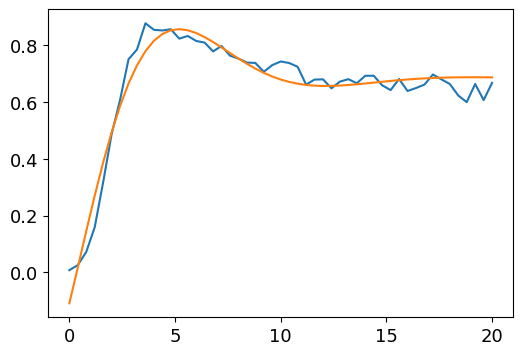



  freq: 0.07205944906199221 +/- 0.0055554633568596365
 gamma: 0.26994230818823306 +/- 0.01966372465228158
   amp: 0.8199967511700422 +/- 0.05249136414586686
 phase: -75.33226977729876 +/- 6.895938043046535
offset: 0.6837237922864973 +/- 0.008341159268729931
pi_pulse time: 6.938715276186107 +/- 0.0055554633568596365
J = 0.23: Angular freq (rad/µs): 0.4527628715897653


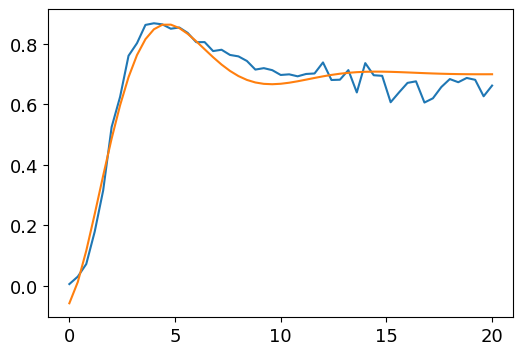



  freq: 0.1008483945066521 +/- 0.006063034595865038
 gamma: 0.3147929596372266 +/- 0.026130943573877564
   amp: 0.7797246785333849 +/- 0.0332670926520682
 phase: -103.60774571724437 +/- 6.640802104200813
offset: 0.7009393964162962 +/- 0.0074911951266262294
pi_pulse time: 4.957937133714303 +/- 0.006063034595865038
J = 0.23500000000000001: Angular freq (rad/µs): 0.633649150616847


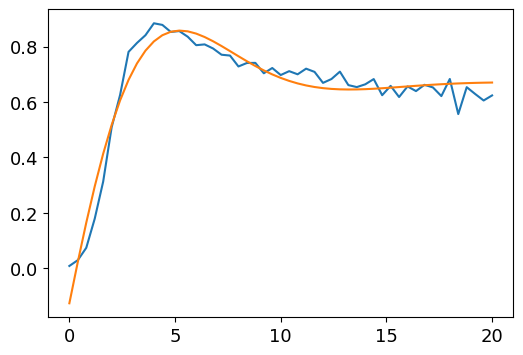



  freq: 0.06233153973492148 +/- 0.0059139297725751975
 gamma: 0.2632978861785588 +/- 0.02038782747214654
   amp: 0.9057130628176815 +/- 0.08658652095677485
 phase: -61.280687300386354 +/- 7.2337347048193745
offset: 0.6680864590856551 +/- 0.00982767676522087
pi_pulse time: 8.021621190914896 +/- 0.0059139297725751975
J = 0.24: Angular freq (rad/µs): 0.3916406146363392


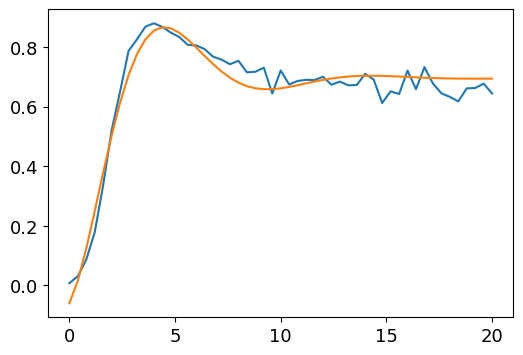



  freq: 0.10253738813600909 +/- 0.0057415507814896185
 gamma: 0.31181485499520506 +/- 0.024213078329571494
   amp: 0.7719711282566565 +/- 0.031514247093879136
 phase: -101.5984606075398 +/- 6.235346751946302
offset: 0.6959585400849266 +/- 0.007115681659231212
pi_pulse time: 4.876270100978025 +/- 0.0057415507814896185
J = 0.245: Angular freq (rad/µs): 0.6442614105727427


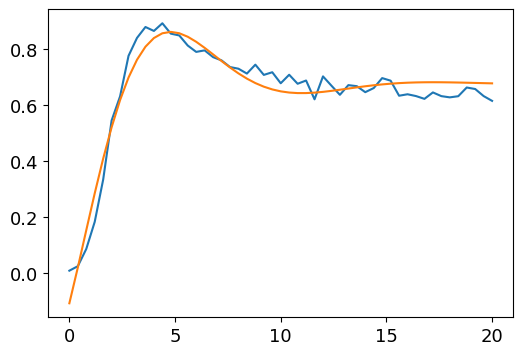



  freq: -0.08059652563968178 +/- 0.005629240607336399
 gamma: 0.27799955411409005 +/- 0.02087101831351423
   amp: -0.8015842266880466 +/- 0.0487365657952281
 phase: 77.69425863799115 +/- 6.602578881748277
offset: 0.6748738648177898 +/- 0.00815501748245699
pi_pulse time: -6.203741365171509 +/- 0.005629240607336399
J = 0.25: Angular freq (rad/µs): 0.5064029057089714


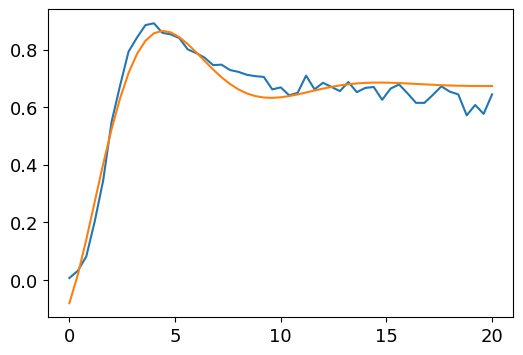



  freq: -0.09795803606919046 +/- 0.005802278292303254
 gamma: 0.28973371881637744 +/- 0.022982634423669143
   amp: 0.7569789297755527 +/- 0.03670504592264488
 phase: -88.57942497550611 +/- 6.507308627229434
offset: 0.6753544907095991 +/- 0.007815584052654485
pi_pulse time: -5.1042264633279935 +/- 0.005802278292303254
J = 0.255: Angular freq (rad/µs): 0.6154884929501054


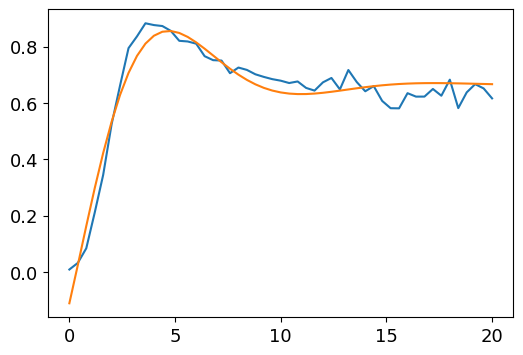



  freq: 0.07975527188921996 +/- 0.005885875215145601
 gamma: 0.27834878132058066 +/- 0.022007879686099255
   amp: 0.8079747862892298 +/- 0.05589199451154385
 phase: -73.87985808795433 +/- 6.7776072761149075
offset: 0.6646375315960741 +/- 0.008570306998174902
pi_pulse time: 6.26917805125785 +/- 0.005885875215145601
J = 0.26: Angular freq (rad/µs): 0.50111715250446


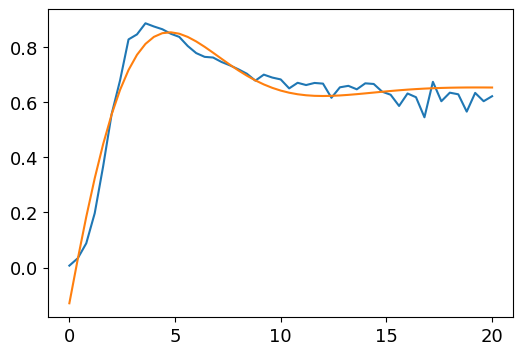



  freq: 0.06887829179437474 +/- 0.006046483194449627
 gamma: 0.2768700338684172 +/- 0.022752098447144438
   amp: 0.8975629759794381 +/- 0.08602658397984393
 phase: -60.110123100845435 +/- 6.757199604503948
offset: 0.6491030419836417 +/- 0.009499655878361726
pi_pulse time: 7.259181187197136 +/- 0.006046483194449627
J = 0.265: Angular freq (rad/µs): 0.4327750709860436


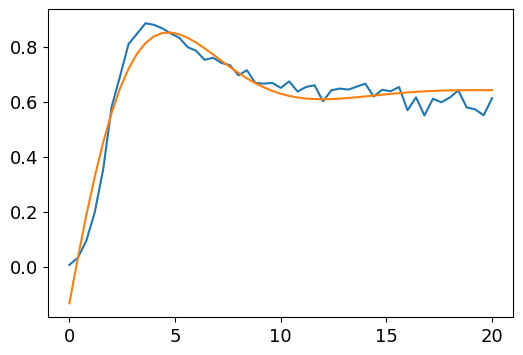



  freq: 0.06857575088170055 +/- 0.005870276431207582
 gamma: 0.2730643890352516 +/- 0.022920132962579113
   amp: 0.9094315478129255 +/- 0.0898820412878291
 phase: -57.988969469952906 +/- 6.508580171158181
offset: 0.6381622646977827 +/- 0.009678999074803707
pi_pulse time: 7.291207074969486 +/- 0.005870276431207582
J = 0.27: Angular freq (rad/µs): 0.43087415036870846


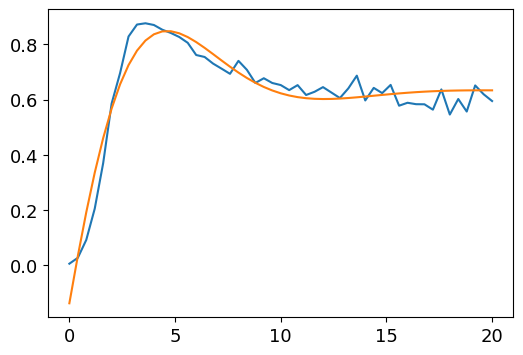



  freq: 0.06726155350964073 +/- 0.006021071568342568
 gamma: 0.27633696444782097 +/- 0.023746045253355868
   amp: 0.9352021657906275 +/- 0.09932539366399103
 phase: -55.09481394439515 +/- 6.50535753421568
offset: 0.6299529695168121 +/- 0.009950922429004682
pi_pulse time: 7.433667138365069 +/- 0.006021071568342568
J = 0.275: Angular freq (rad/µs): 0.4226168047498482


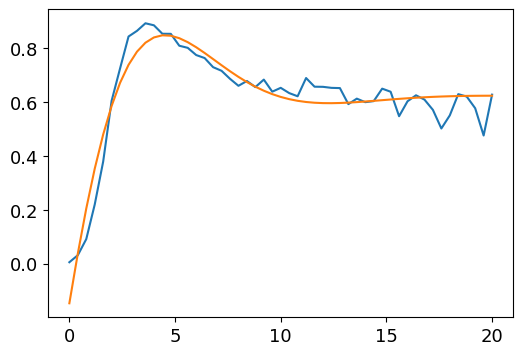



  freq: 0.06433011818082374 +/- 0.006982589518737805
 gamma: 0.28402338564673013 +/- 0.027702565461858918
   amp: 1.0050374877529753 +/- 0.1336895679501613
 phase: -49.85003310475256 +/- 7.15930594387538
offset: 0.6212511421143071 +/- 0.011609936121262094
pi_pulse time: 7.77240916291439 +/- 0.006982589518737805
J = 0.28: Angular freq (rad/µs): 0.40419805336287806


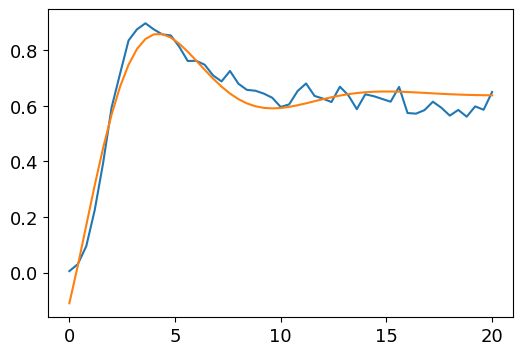



  freq: 0.09270422835435592 +/- 0.005679318376564931
 gamma: 0.2754930210797248 +/- 0.023033225016310374
   amp: 0.7737631745188072 +/- 0.051889568593634035
 phase: -75.95366370134187 +/- 6.284890838922677
offset: 0.6405767527054357 +/- 0.008526829105870755
pi_pulse time: 5.393497242529028 +/- 0.005679318376564931
J = 0.28500000000000003: Angular freq (rad/µs): 0.5824778455095103


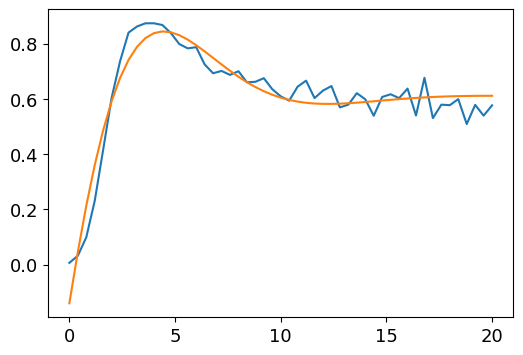



  freq: 0.06430160764292703 +/- 0.006210646318413265
 gamma: 0.2813753421065306 +/- 0.02572651582108932
   amp: 1.0074523844046384 +/- 0.12482613364527667
 phase: -47.9560238081109 +/- 6.267419672378228
offset: 0.6081400195144853 +/- 0.010678533592382192
pi_pulse time: 7.77585535305039 +/- 0.006210646318413265
J = 0.29: Angular freq (rad/µs): 0.4040189163700657


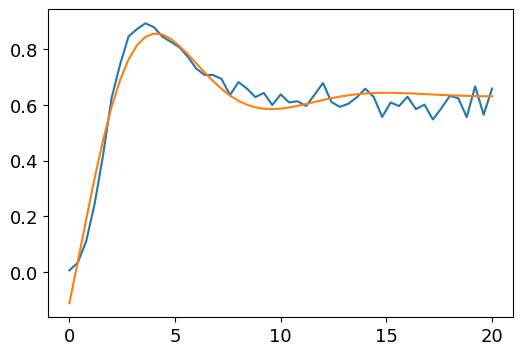



  freq: 0.09164586454515951 +/- 0.005537205352682758
 gamma: 0.2813918036758149 +/- 0.022821569909021736
   amp: 0.7878806841075116 +/- 0.05517595868065236
 phase: -71.16227621805731 +/- 5.903230522313823
offset: 0.6328834185616885 +/- 0.008178499636155055
pi_pulse time: 5.455783547697556 +/- 0.005537205352682758
J = 0.295: Angular freq (rad/µs): 0.5758279495739168


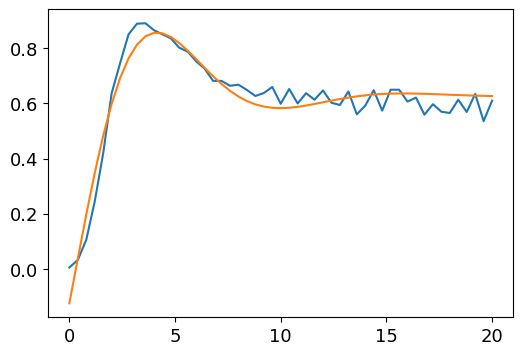



  freq: 0.08570178208651529 +/- 0.005611627218599659
 gamma: 0.28080473559779806 +/- 0.023538538558562735
   amp: 0.827865327685797 +/- 0.06593835796494232
 phase: -65.29624024071136 +/- 5.909649682375574
offset: 0.6274689916079162 +/- 0.008667176653942997
pi_pulse time: 5.834184398817447 +/- 0.005611627218599659
J = 0.3: Angular freq (rad/µs): 0.5384801780050995


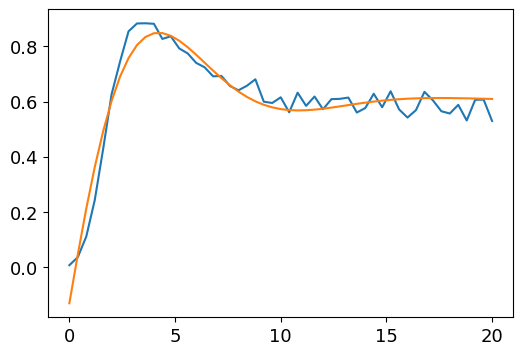



  freq: 0.0754509122435856 +/- 0.0052875529489863566
 gamma: 0.27674544889560093 +/- 0.023419737013464045
   amp: 0.9029113944921952 +/- 0.08467255504202419
 phase: -54.7885626388548 +/- 5.420738155065406
offset: 0.6065110761361926 +/- 0.00900863079993149
pi_pulse time: 6.6268251122769835 +/- 0.0052875529489863566
J = 0.305: Angular freq (rad/µs): 0.4740720632221934


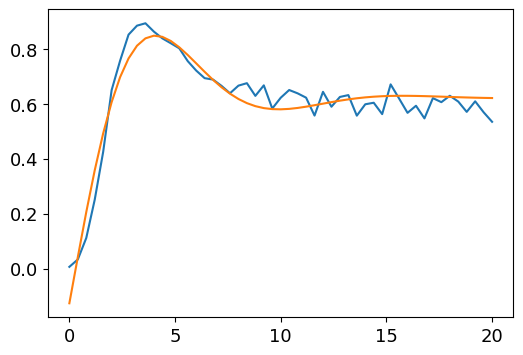



  freq: 0.0854897825141104 +/- 0.006150157722381357
 gamma: 0.2895862216859408 +/- 0.02570708462500037
   amp: 0.8356736674718188 +/- 0.07300455499761636
 phase: -63.45069060506865 +/- 6.2635599796158745
offset: 0.6215824898610143 +/- 0.00905291551608197
pi_pulse time: 5.848652146441865 +/- 0.006150157722381357
J = 0.31: Angular freq (rad/µs): 0.5371481454066367


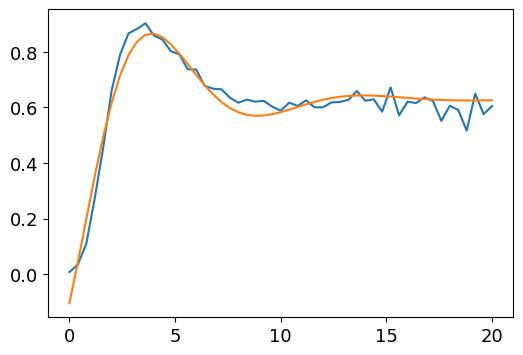



  freq: 0.09980894151970826 +/- 0.004920036703380017
 gamma: 0.278187056134432 +/- 0.021019450105007633
   amp: 0.7650847223373973 +/- 0.046979691047746575
 phase: -73.46741469389531 +/- 5.207320633808431
offset: 0.6287440573242347 +/- 0.007370396885208206
pi_pulse time: 5.009571210624151 +/- 0.004920036703380017
J = 0.315: Angular freq (rad/µs): 0.6271180748817775


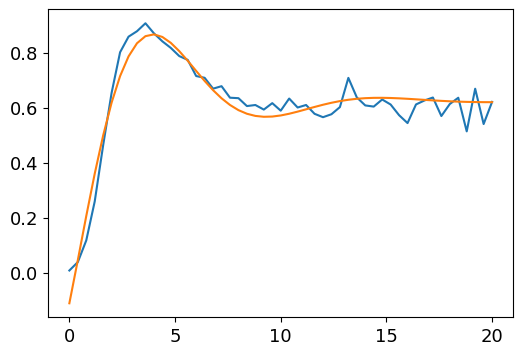



  freq: 0.09333500484882681 +/- 0.005156240035964392
 gamma: 0.2738616906253063 +/- 0.022570969219940246
   amp: 0.7932922616243523 +/- 0.05755844050414545
 phase: -67.74091785796391 +/- 5.458878576843691
offset: 0.622348617912716 +/- 0.008220222115030432
pi_pulse time: 5.357046917282983 +/- 0.005156240035964392
J = 0.32: Angular freq (rad/µs): 0.586441131111684


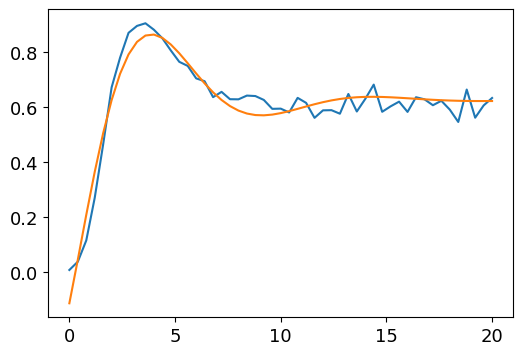



  freq: 0.09579817546210617 +/- 0.005134774574582816
 gamma: 0.2822815448712825 +/- 0.022132313629527316
   amp: 0.792260916162449 +/- 0.05407952895344268
 phase: -68.89849828661963 +/- 5.310155484256985
offset: 0.6257354598470056 +/- 0.007746452238295048
pi_pulse time: 5.219306083734126 +/- 0.005134774574582816
J = 0.325: Angular freq (rad/µs): 0.6019176885181174


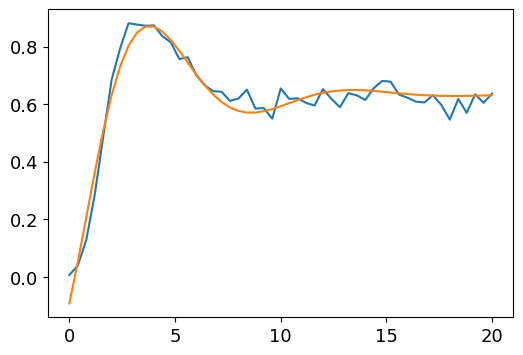



  freq: 0.1040840547018524 +/- 0.004439821072768353
 gamma: 0.279210051831278 +/- 0.019139211585849643
   amp: 0.7496144638569526 +/- 0.040455884603829574
 phase: -75.18754832470665 +/- 4.666595065971666
offset: 0.6326938334045477 +/- 0.006525259885206409
pi_pulse time: 4.803809780780008 +/- 0.004439821072768353
J = 0.33: Angular freq (rad/µs): 0.6539794032143553


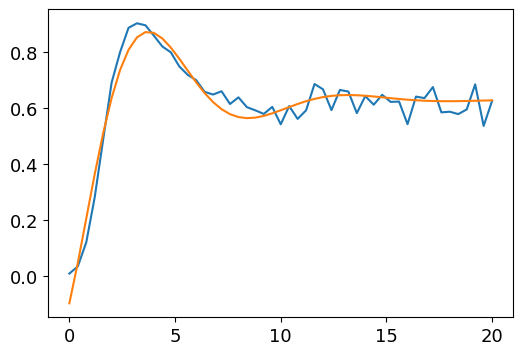



  freq: 0.1059666361333774 +/- 0.0051158357615542415
 gamma: 0.27946871882690083 +/- 0.022250736689738777
   amp: 0.7517283865558139 +/- 0.04678565293677158
 phase: -75.37773600017132 +/- 5.34973167974611
offset: 0.6299492236927315 +/- 0.007564721136720265
pi_pulse time: 4.7184662856586606 +/- 0.0051158357615542415
J = 0.335: Angular freq (rad/µs): 0.6658080112044823


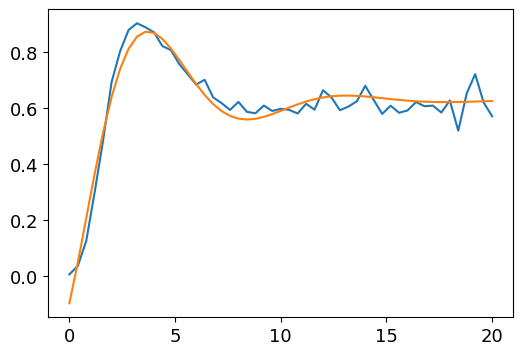



  freq: 0.10661668412981898 +/- 0.004684203323441899
 gamma: 0.2774452715104082 +/- 0.020593556268504985
   amp: 0.748815119518741 +/- 0.04350318910128848
 phase: -74.97554938877964 +/- 4.907463961221366
offset: 0.6260990479713645 +/- 0.007013719519624803
pi_pulse time: 4.68969752793276 +/- 0.004684203323441899
J = 0.34: Angular freq (rad/µs): 0.6698923832246856


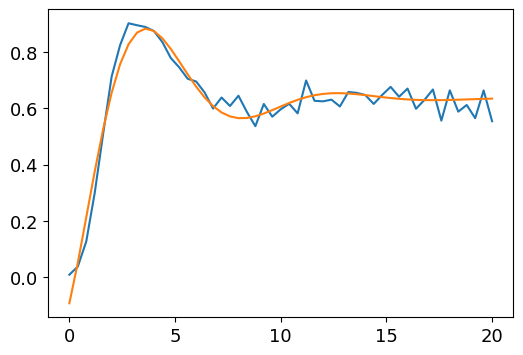



  freq: 0.11061714229172306 +/- 0.004748267312059941
 gamma: 0.2812102947840489 +/- 0.020903318704484305
   amp: 0.7463808264891842 +/- 0.042194866786108495
 phase: -76.85065307652907 +/- 4.915140104032453
offset: 0.6342111903619747 +/- 0.006961137275434878
pi_pulse time: 4.5200950742461234 +/- 0.004748267312059941
J = 0.34500000000000003: Angular freq (rad/µs): 0.6950280031695479


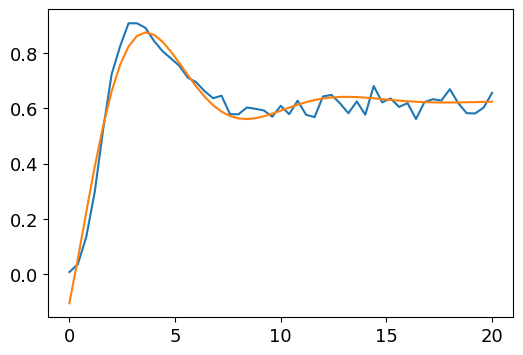



  freq: 0.10566111921172354 +/- 0.004752706036352657
 gamma: 0.2875674054907473 +/- 0.021029125255132786
   amp: 0.7722418129463968 +/- 0.0464128084383776
 phase: -71.3135507151372 +/- 4.768991106535474
offset: 0.6258451242659031 +/- 0.00691551952508722
pi_pulse time: 4.732109632476076 +/- 0.004752706036352657
J = 0.35000000000000003: Angular freq (rad/µs): 0.663888391771252


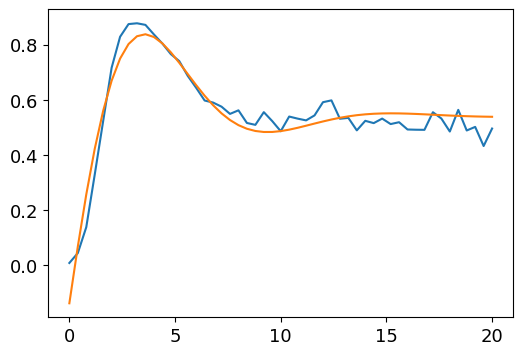



  freq: 0.08573724904691785 +/- 0.004800326992366697
 gamma: 0.2832953271682546 +/- 0.025713262568674587
   amp: 0.9200110751332027 +/- 0.08717733602630202
 phase: -47.408446761484804 +/- 4.320516245858378
offset: 0.5401793509168221 +/- 0.008862970146074943
pi_pulse time: 5.831770969539574 +/- 0.004800326992366697
J = 0.355: Angular freq (rad/µs): 0.5387030234895912


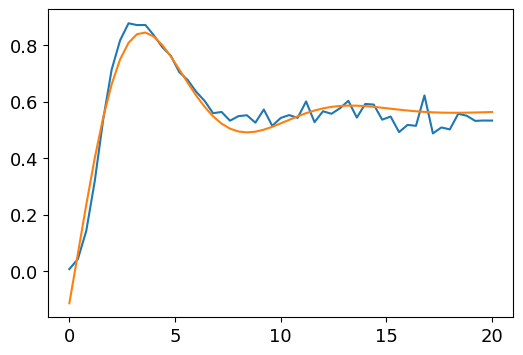



  freq: 0.10193437434608858 +/- 0.004335625487081722
 gamma: 0.26835546897900586 +/- 0.02175399047567831
   amp: 0.7744516237529175 +/- 0.055269518191398366
 phase: -61.27076173979409 +/- 4.367982953767931
offset: 0.565843940209494 +/- 0.007411536907362926
pi_pulse time: 4.9051166812717675 +/- 0.004335625487081722
J = 0.36: Angular freq (rad/µs): 0.6404725631878875


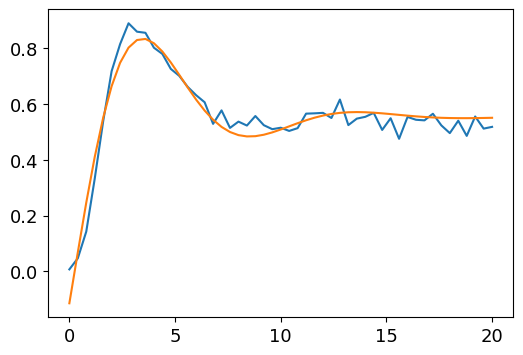



  freq: 0.09880307066817764 +/- 0.004282683335377339
 gamma: 0.27419602129912163 +/- 0.021975552570502984
   amp: 0.79427746649733 +/- 0.058503871987024406
 phase: -57.225473726331586 +/- 4.155143782885082
offset: 0.5539143447161711 +/- 0.00728088106172914
pi_pulse time: 5.060571464212997 +/- 0.004282683335377339
J = 0.365: Angular freq (rad/µs): 0.6207980019265201


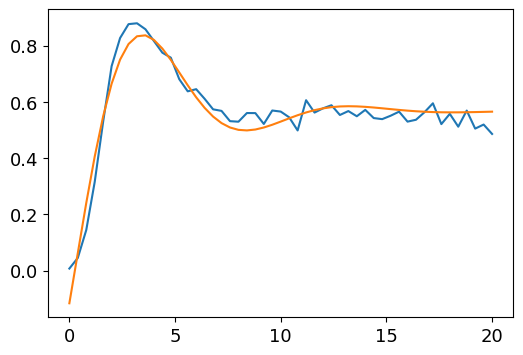



  freq: 0.10241476073711892 +/- 0.004697224405004485
 gamma: 0.2809833021017277 +/- 0.023120215993124613
   amp: 0.7808345083455572 +/- 0.05747503794859623
 phase: -61.07254915463391 +/- 4.551736550534984
offset: 0.5674764718057997 +/- 0.007438246014038022
pi_pulse time: 4.882108754649284 +/- 0.004697224405004485
J = 0.37: Angular freq (rad/µs): 0.6434909199017783


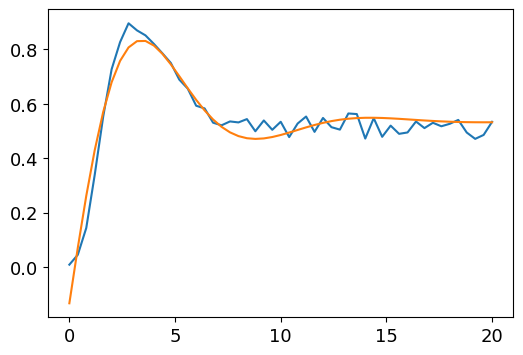



  freq: 0.09247344188836693 +/- 0.004518841152064785
 gamma: 0.28442785362577616 +/- 0.02435833321744719
   amp: 0.877424538161378 +/- 0.07466893216769052
 phase: -49.68857482621616 +/- 4.066755301380014
offset: 0.5349936502989866 +/- 0.008048123875829906
pi_pulse time: 5.406957822588623 +/- 0.004518841152064785
J = 0.375: Angular freq (rad/µs): 0.5810277713773123


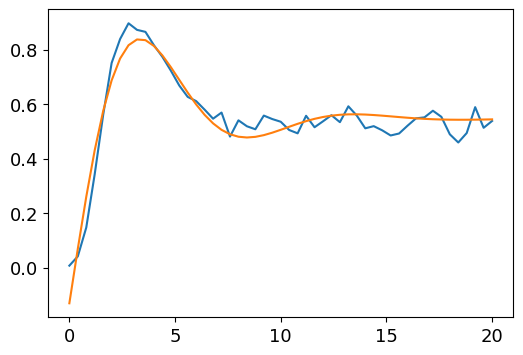



  freq: 0.09890594528399528 +/- 0.004820727241632873
 gamma: 0.28583058999724054 +/- 0.025323466259102922
   amp: 0.8379939696281474 +/- 0.07033732462306969
 phase: -53.920093995311426 +/- 4.410094493731309
offset: 0.5464785878353571 +/- 0.008127296236739278
pi_pulse time: 5.055307833763849 +/- 0.004820727241632873
J = 0.38: Angular freq (rad/µs): 0.6214443822011072


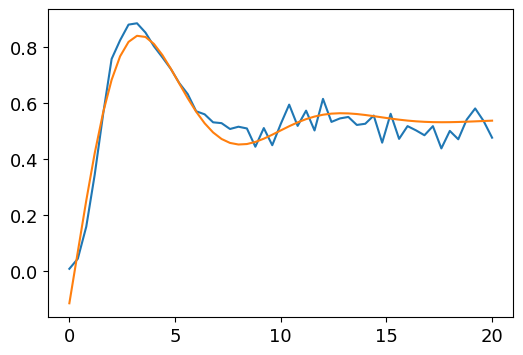



  freq: 0.10481876874820613 +/- 0.004297145800542611
 gamma: 0.2614881718947119 +/- 0.023349839250795788
   amp: 0.7772651846204292 +/- 0.06088596375271144
 phase: -57.22491193995642 +/- 4.278739332437889
offset: 0.5381843389750398 +/- 0.007970873447307519
pi_pulse time: 4.770138077094681 +/- 0.004297145800542611
J = 0.385: Angular freq (rad/µs): 0.6585957477153835


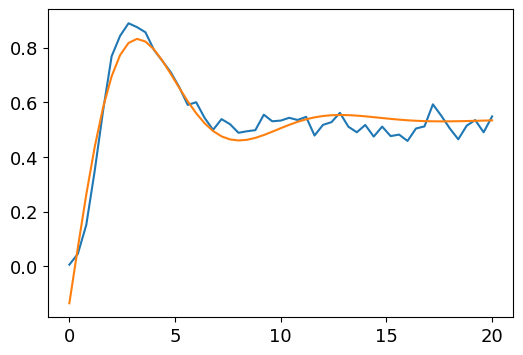



  freq: 0.10408384633061861 +/- 0.00498572722675899
 gamma: 0.2876906003177196 +/- 0.02663245088460205
   amp: 0.8213464830427175 +/- 0.0700785828076022
 phase: -54.6670255878565 +/- 4.510808515324914
offset: 0.5345770663980619 +/- 0.008258644478714154
pi_pulse time: 4.803819397793658 +/- 0.00498572722675899
J = 0.39: Angular freq (rad/µs): 0.6539780939792808


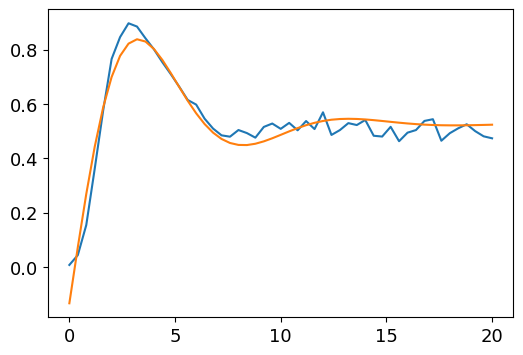



  freq: 0.10038904799457335 +/- 0.004172678463974341
 gamma: 0.27895966351624657 +/- 0.023243851361737084
   amp: 0.8452838043691799 +/- 0.06597119179213926
 phase: -51.29471964665153 +/- 3.798480390572429
offset: 0.5259806141279008 +/- 0.007601290953476228
pi_pulse time: 4.980622986155105 +/- 0.004172678463974341
J = 0.395: Angular freq (rad/µs): 0.6307629913612496


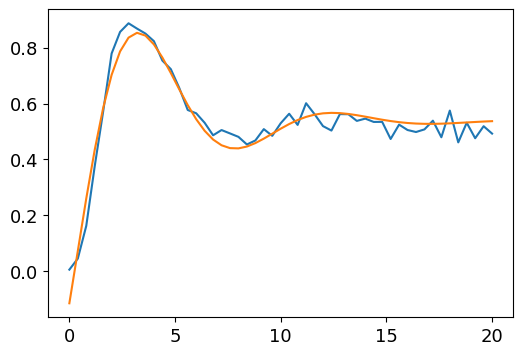



  freq: 0.10863363177732145 +/- 0.0034485676193043483
 gamma: 0.25566401050186344 +/- 0.019301010230463485
   amp: 0.773828991998138 +/- 0.050057830450971334
 phase: -57.24994849081125 +/- 3.477618023382178
offset: 0.5366731478567688 +/- 0.006710987505415996
pi_pulse time: 4.602626201661987 +/- 0.0034485676193043483
J = 0.4: Angular freq (rad/µs): 0.6825652390488235


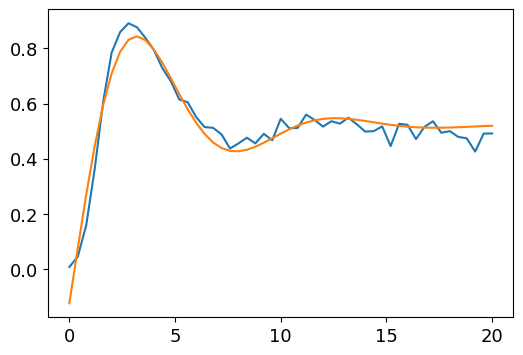



  freq: 0.10629889719545153 +/- 0.0036790632987520333
 gamma: 0.26419382713325074 +/- 0.021161310067193927
   amp: 0.8060894570896237 +/- 0.057253095274879304
 phase: -53.08415017603344 +/- 3.5178517525684496
offset: 0.5200314421342875 +/- 0.0071429416319969624
pi_pulse time: 4.703717660218536 +/- 0.0036790632987520333
J = 0.405: Angular freq (rad/µs): 0.6678956690278544


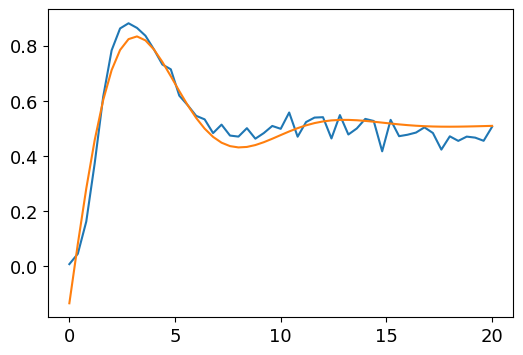



  freq: 0.10138622478499332 +/- 0.0045154157693230645
 gamma: 0.28229852956337115 +/- 0.026075997048037116
   amp: 0.8584538458744945 +/- 0.0746807567172045
 phase: -48.76052060951485 +/- 3.975797373481047
offset: 0.5112556275782065 +/- 0.00832885078350651
pi_pulse time: 4.931636433453704 +/- 0.0045154157693230645
J = 0.41000000000000003: Angular freq (rad/µs): 0.6370284379194768


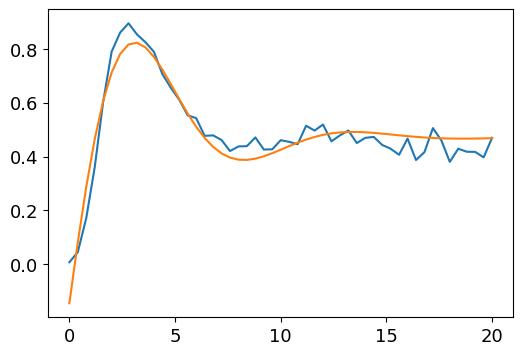



  freq: 0.09689291144298103 +/- 0.004247895759260767
 gamma: 0.27729075760007416 +/- 0.02651290545758191
   amp: 0.9136534972457896 +/- 0.08427947486586983
 phase: -42.44796582458922 +/- 3.6089203036583655
offset: 0.47140010144279776 +/- 0.008874255567455426
pi_pulse time: 5.16033621607332 +/- 0.004247895759260767
J = 0.41500000000000004: Angular freq (rad/µs): 0.6087961175483911


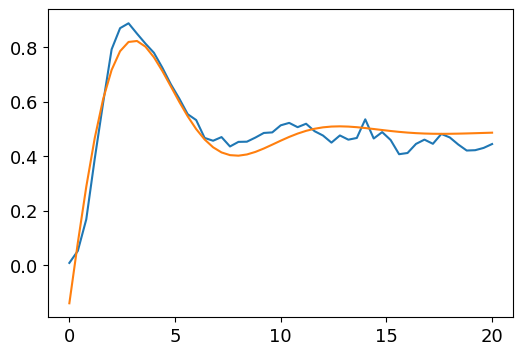



  freq: 0.10286504281963779 +/- 0.004442569445388174
 gamma: 0.28112874783619757 +/- 0.026791889656612194
   amp: 0.8656697110236987 +/- 0.07725893861366818
 phase: -46.424549784375806 +/- 3.835860510758485
offset: 0.487433229723534 +/- 0.00850664467384323
pi_pulse time: 4.860737781217798 +/- 0.004442569445388174
J = 0.42: Angular freq (rad/µs): 0.6463201256667471


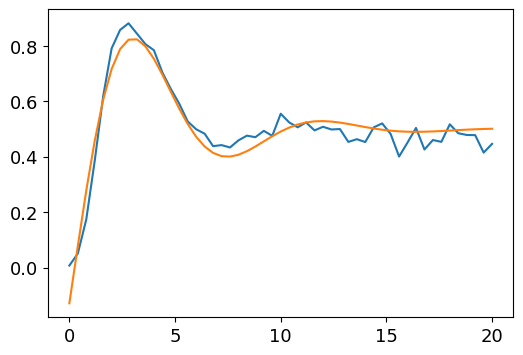



  freq: 0.1122409241190965 +/- 0.00407280496439181
 gamma: 0.26916658869098087 +/- 0.02402514320377252
   amp: 0.7895202345273656 +/- 0.0614254343152663
 phase: -52.623956659361085 +/- 3.7851561241137035
offset: 0.4989195903018925 +/- 0.007639343017987749
pi_pulse time: 4.454703165749602 +/- 0.00407280496439181
J = 0.425: Angular freq (rad/µs): 0.705230525289366


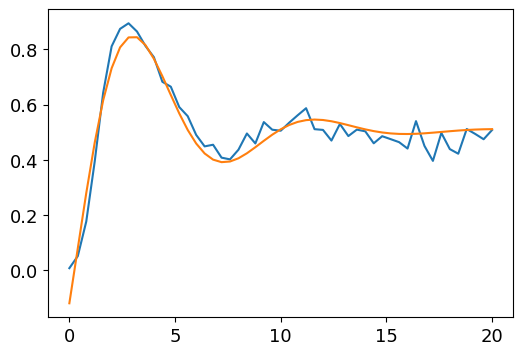



  freq: 0.11617139222125153 +/- 0.003672579984837178
 gamma: 0.25145736013012193 +/- 0.021995527792743535
   amp: 0.7674432059175648 +/- 0.0562044172600741
 phase: -54.65280711791628 +/- 3.654805626825682
offset: 0.5071281945792058 +/- 0.007552933305984371
pi_pulse time: 4.303985606436881 +/- 0.003672579984837178
J = 0.43: Angular freq (rad/µs): 0.7299263847191645


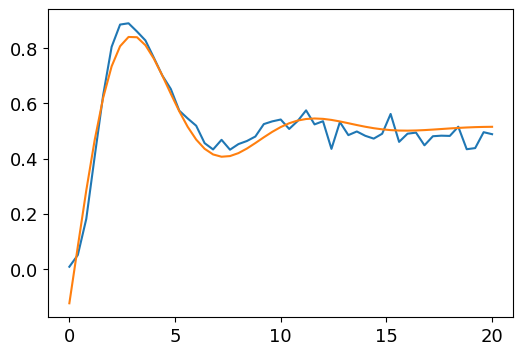



  freq: 0.11581216874706374 +/- 0.0038522444044015265
 gamma: 0.2658432846723244 +/- 0.02262208789027889
   amp: 0.7822894996680853 +/- 0.056744107986415916
 phase: -54.44593558478886 +/- 3.6461326955563726
offset: 0.5119422746702155 +/- 0.007314454761177326
pi_pulse time: 4.317335608246926 +/- 0.0038522444044015265
J = 0.435: Angular freq (rad/µs): 0.7276693170641537


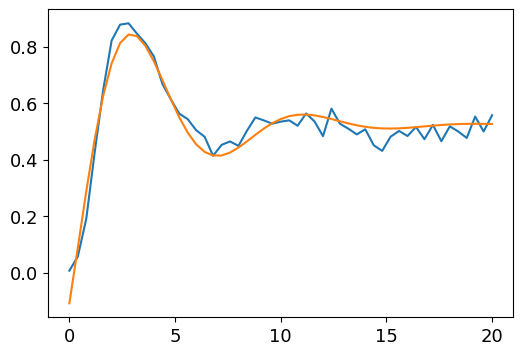



  freq: 0.12287985402916292 +/- 0.0037215689904110537
 gamma: 0.2653362824109127 +/- 0.021302592841211013
   amp: 0.7405282132568297 +/- 0.048887014310602765
 phase: -58.446661088314 +/- 3.5819240869060716
offset: 0.5229555843578052 +/- 0.006673421349739636
pi_pulse time: 4.069015250305682 +/- 0.0037215689904110537
J = 0.44: Angular freq (rad/µs): 0.7720768933844088


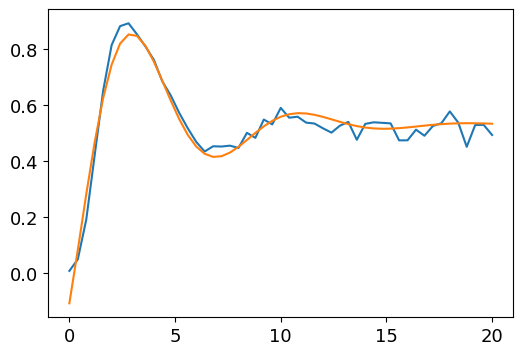



  freq: 0.12552299302109882 +/- 0.0032231017237913224
 gamma: 0.25896862621146244 +/- 0.018244441346678637
   amp: 0.7318296353520501 +/- 0.04145749883356406
 phase: -60.869261328035826 +/- 3.201554024244661
offset: 0.5302937940240317 +/- 0.005920342801840912
pi_pulse time: 3.9833339531344376 +/- 0.0032231017237913224
J = 0.445: Angular freq (rad/µs): 0.7886842254633738


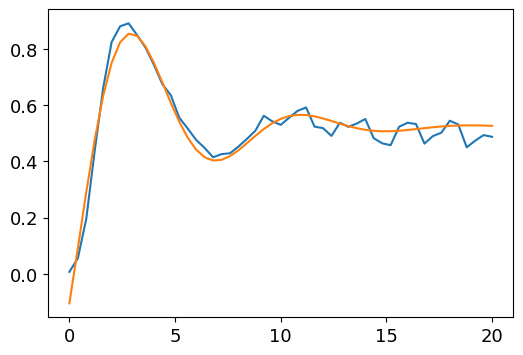



  freq: 0.12459180535375641 +/- 0.003167793036704959
 gamma: 0.25431590257564374 +/- 0.01843649741407179
   amp: 0.7346572723122671 +/- 0.04311612160211745
 phase: -58.663848018330945 +/- 3.1612778462728097
offset: 0.5226129384404856 +/- 0.0060832858994066576
pi_pulse time: 4.013105023884503 +/- 0.003167793036704959
J = 0.45: Angular freq (rad/µs): 0.7828334007937012


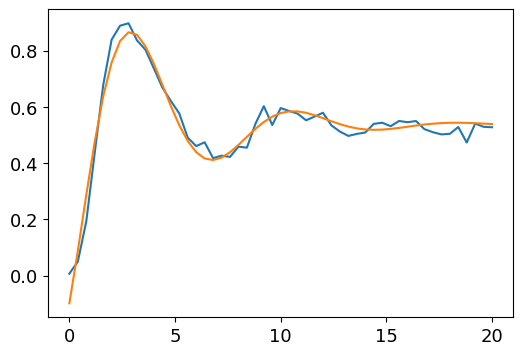



  freq: 0.12999377169362974 +/- 0.0029641796211282607
 gamma: 0.25062400634339965 +/- 0.016789968034001502
   amp: 0.7136645069953719 +/- 0.03749540037417801
 phase: -62.79973830970204 +/- 3.04500485147822
offset: 0.53637910102992 +/- 0.005611928434204569
pi_pulse time: 3.846338124401864 +/- 0.0029641796211282607
J = 0.455: Angular freq (rad/µs): 0.816774956330272


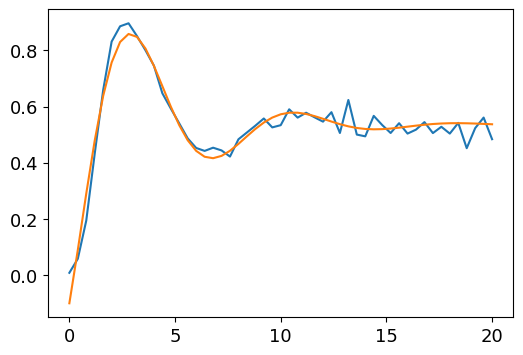



  freq: 0.12956025373963334 +/- 0.0033267922954443845
 gamma: 0.25961267377549024 +/- 0.018741526711157534
   amp: 0.7195647427292554 +/- 0.04119083334059564
 phase: -62.08136436610307 +/- 3.302460145922943
offset: 0.534800449902888 +/- 0.005990959116588685
pi_pulse time: 3.859208249196618 +/- 0.0033267922954443845
J = 0.46: Angular freq (rad/µs): 0.8140510826913232


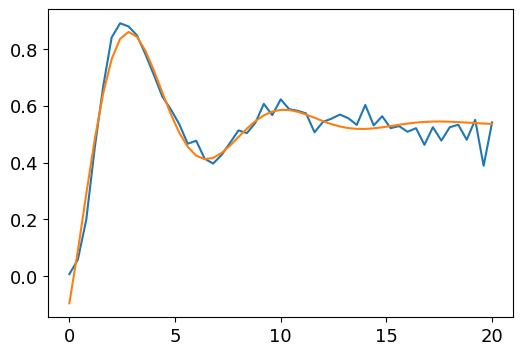



  freq: 0.1364051236810321 +/- 0.0038418641115041197
 gamma: 0.25757457840436787 +/- 0.02131846018625154
   amp: 0.6966994769768807 +/- 0.04441060561206554
 phase: -65.21416244567983 +/- 3.8736260713924566
offset: 0.5371713861764649 +/- 0.0067724565598372664
pi_pulse time: 3.665551458090337 +/- 0.0038418641115041197
J = 0.465: Angular freq (rad/µs): 0.8570586689366751


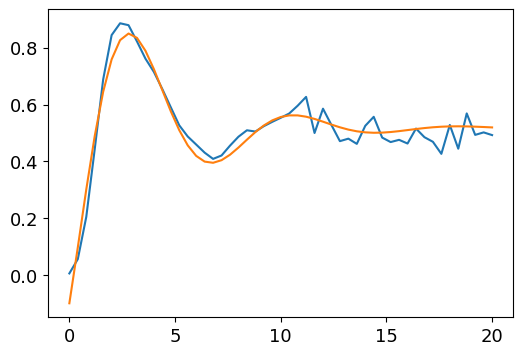



  freq: 0.1287003391458058 +/- 0.0036566391179001486
 gamma: 0.2569756852818622 +/- 0.021384359415333936
   amp: 0.7204087654976333 +/- 0.04817993602316465
 phase: -58.64667344228607 +/- 3.598156020459941
offset: 0.5173659813350073 +/- 0.006810629609850851
pi_pulse time: 3.884993647402478 +/- 0.0036566391179001486
J = 0.47000000000000003: Angular freq (rad/µs): 0.8086480799499568


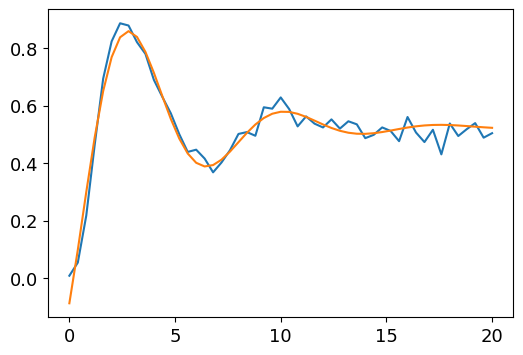



  freq: 0.13563485936163344 +/- 0.0029277245923969766
 gamma: 0.24458006601221977 +/- 0.01693258903807687
   amp: 0.6897875790437348 +/- 0.03695713268599974
 phase: -62.38524788016571 +/- 3.0512163340745615
offset: 0.5236907057136474 +/- 0.005641215584458086
pi_pulse time: 3.6863679614020617 +/- 0.0029277245923969766
J = 0.47500000000000003: Angular freq (rad/µs): 0.8522189554823848


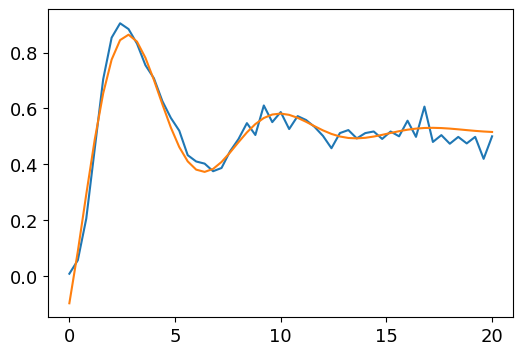



  freq: 0.1390099368597053 +/- 0.003134511536451172
 gamma: 0.23782064371796677 +/- 0.01815779566392607
   amp: 0.6896131452788894 +/- 0.040173151221604475
 phase: -63.484139141975426 +/- 3.3587989753387673
offset: 0.519165864186224 +/- 0.006323191032720588
pi_pulse time: 3.5968651687441673 +/- 0.003134511536451172
J = 0.48: Angular freq (rad/µs): 0.8734251928288623


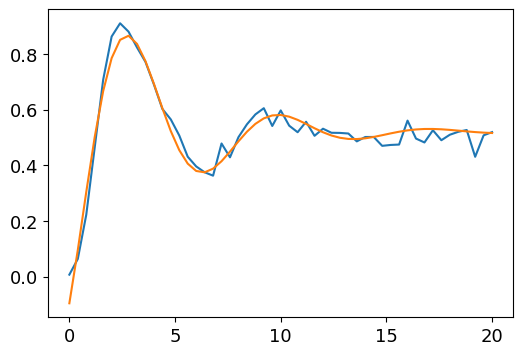



  freq: 0.13982513493789303 +/- 0.0029737719879189242
 gamma: 0.24214388152933658 +/- 0.01733044819256278
   amp: 0.6944168084999948 +/- 0.038147637363669405
 phase: -62.40054417278586 +/- 3.117339765643261
offset: 0.5200025899586281 +/- 0.005894231917946645
pi_pulse time: 3.5758949935724216 +/- 0.0029737719879189242
J = 0.485: Angular freq (rad/µs): 0.8785472334161725


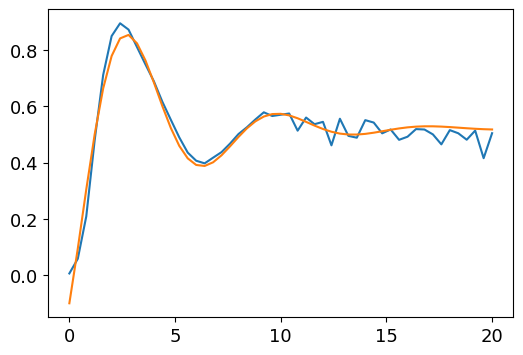



  freq: 0.14002024360839793 +/- 0.003234466844968944
 gamma: 0.2572731536322632 +/- 0.0184998558413573
   amp: 0.6972170135150683 +/- 0.03881760494475169
 phase: -62.64739923697079 +/- 3.2135665072875566
offset: 0.5203840173109652 +/- 0.0058079097349522605
pi_pulse time: 3.570912227508878 +/- 0.003234466844968944
J = 0.49: Angular freq (rad/µs): 0.8797731373479922


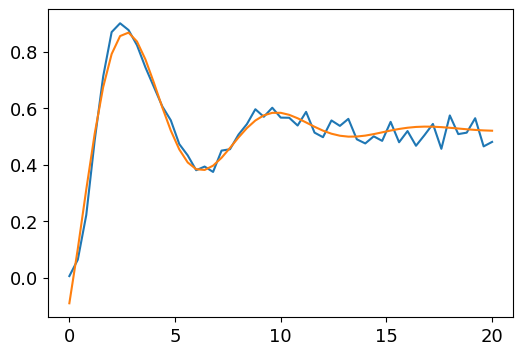



  freq: 0.14080907610613455 +/- 0.003055047333838329
 gamma: 0.24542734535964428 +/- 0.01776435645198438
   amp: 0.6934123453325782 +/- 0.03855686049788332
 phase: -62.37455815940348 +/- 3.1609291515262834
offset: 0.5238936421237229 +/- 0.0059186805927977605
pi_pulse time: 3.5509074686572477 +/- 0.003055047333838329
J = 0.495: Angular freq (rad/µs): 0.8847295181075967
J = 0.0: omega = 0.36874393558851165 rad/µs
J = 0.005: omega = 0.34507151310264345 rad/µs
J = 0.01: omega = 0.35983741519882084 rad/µs
J = 0.015: omega = 0.36385834658801713 rad/µs
J = 0.02: omega = 0.35746623475437234 rad/µs
J = 0.025: omega = 0.37779926793235186 rad/µs
J = 0.03: omega = 0.40267228625121176 rad/µs
J = 0.035: omega = 0.3548295302281021 rad/µs
J = 0.04: omega = 0.36828350679524585 rad/µs
J = 0.045: omega = 0.3714923346539144 rad/µs
J = 0.05: omega = 0.37873374572985696 rad/µs
J = 0.055: omega = 0.3905838564110537 rad/µs
J = 0.06: omega = 0.410593766598019 rad/µs
J = 0.065: omega = 0.4049440067552156 rad/

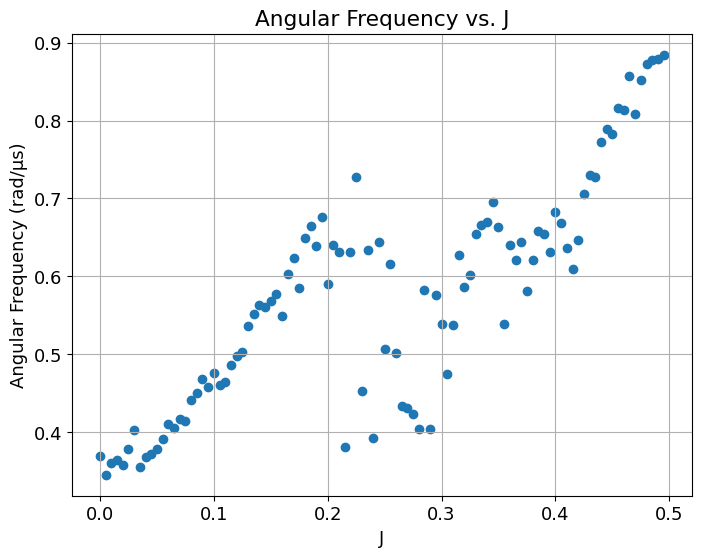

C:\Users\quantum1\AppData\Local\Temp\ipykernel_7364\909373872.py:17: RuntimeWarning: invalid value encountered in sqrt
  return np.where(expr >= 0, np.sqrt(expr), 0.0)
C:\Users\quantum1\AppData\Local\Temp\ipykernel_7364\909373872.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, J_data, y_data, p0=[initial_guess_J0])


Fitted J0 = -9.607962308718623e-07


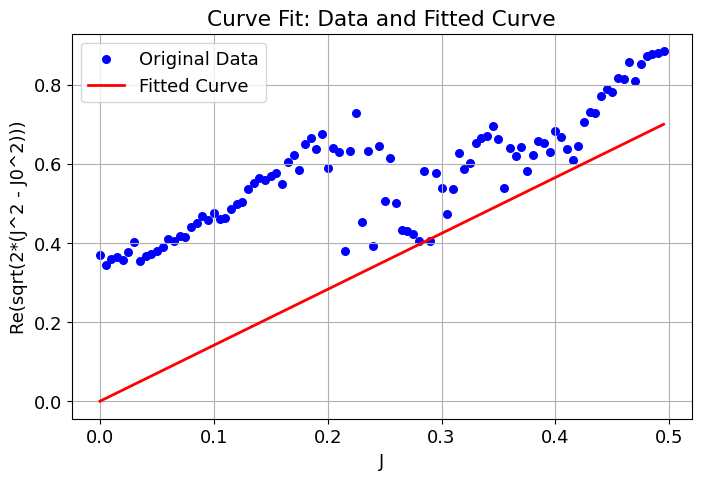

In [10]:
# Now call the function to process each J value and extract the angular frequency
probs_folder = os.path.join("sweep_J_data", "probs")
values_folder = os.path.join("sweep_J_data", "values")
probability_dataframes = {}
for J in J_list:
    prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
    values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

    # If both files already exist, load them and skip this iteration
    if os.path.exists(prob_filename) and os.path.exists(values_filename):
        with open(prob_filename, "rb") as f:
            df_prob = pickle.load(f)
        probability_dataframes[J] = df_prob
# probability_dataframes = 0
omega_dict = sweep_J_curve_fit(probability_dataframes)

# Print the results
for J, omega in omega_dict.items():
    print(f"J = {J}: omega = {omega} rad/µs")
J_vals = sorted(omega_dict.keys())
omegas = [omega_dict[J] for J in J_vals]

plt.figure(figsize=(8, 6))
plt.scatter(J_vals, omegas, marker="o")
plt.xlabel("J")
plt.ylabel("Angular Frequency (rad/µs)")
plt.title("Angular Frequency vs. J")
plt.grid(True)
plt.show()
# Set initial guesses based on your expectations:
initial_guess_J0 = 0.1  # for example
initial_offset = 0.0  # for example
mask_rb = ~np.isnan(omegas)

# Perform the curve fitting and plotting
popt, pcov = curve_fit_and_plot(
    np.array(J_vals)[mask_rb], np.array(omegas)[mask_rb], initial_guess_J0
)

<Figure size 960x720 with 0 Axes>

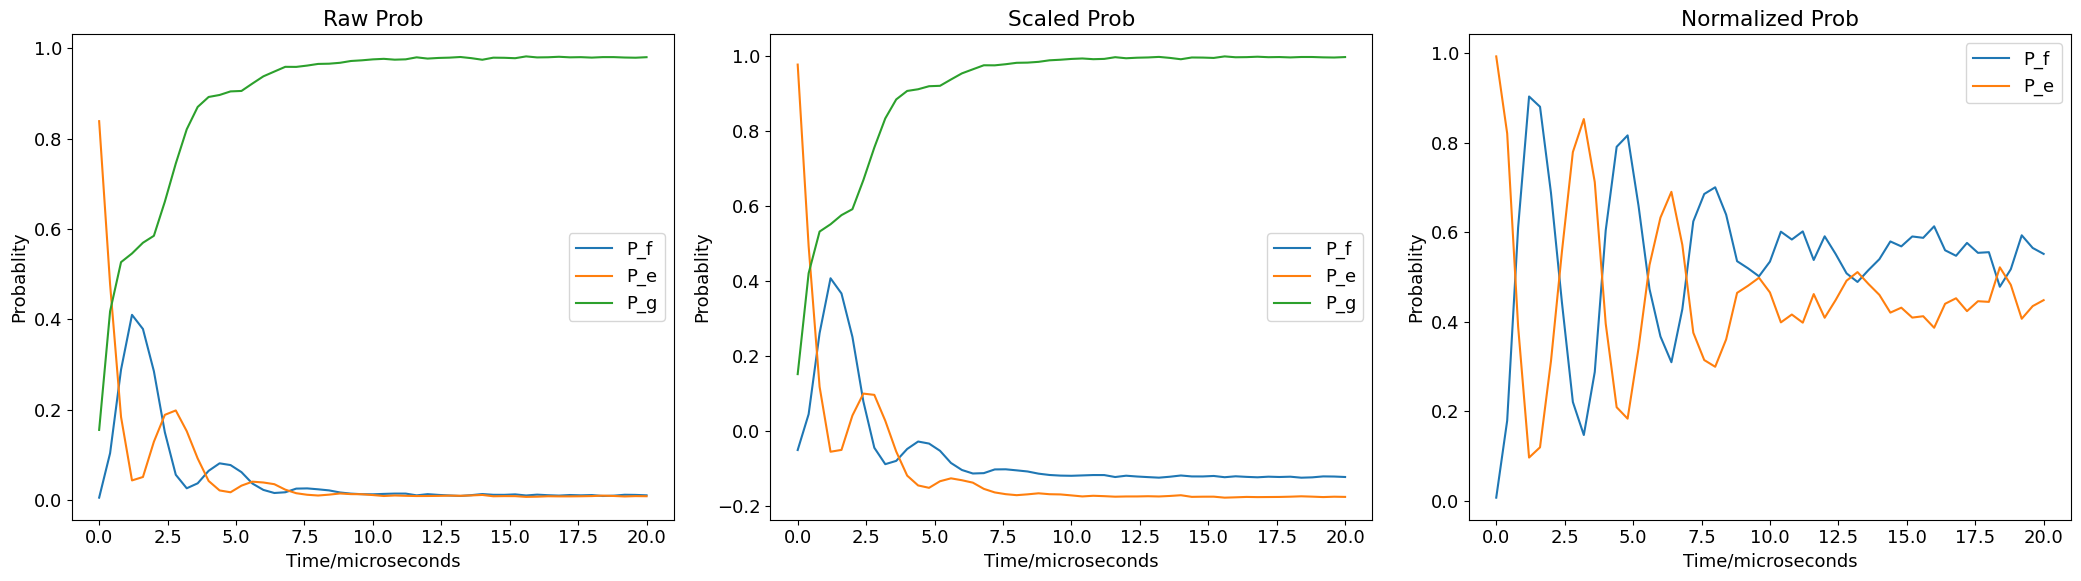

In [ ]:
scale_matrix = np.array(
    [
        [1.01788813, -0.0081921, -0.00969603],
        [-0.19047774, 1.201006, -0.01052826],
        [-0.13825531, -0.04327379, 1.18152911],
    ]
)
J = 1
measured_pop = np.array(
    [
        probability_dataframes[J]["P_g"],
        probability_dataframes[J]["P_e"],
        probability_dataframes[J]["P_f"],
    ]
)
scaled_p = np.matmul(scale_matrix, measured_pop)
scaled_df = pd.DataFrame(
    {
        "time": probability_dataframes[J]["time"],
        "P_g": scaled_p[0],
        "P_e": scaled_p[1],
        "P_f": scaled_p[2],
    }
)
normalization_val = probability_dataframes[J]["P_f"] + probability_dataframes[J]["P_e"]
normalized_df = pd.DataFrame(
    {
        "time": probability_dataframes[J]["time"],
        "P_f": probability_dataframes[J]["P_f"] / normalization_val,
        "P_e": probability_dataframes[J]["P_e"] / normalization_val,
        "P_g": probability_dataframes[J]["P_g"] / normalization_val,
    }
)
keys = ["P_f", "P_e", "P_g"]
plt.figure(dpi=150)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for key in keys:
    sns.lineplot(data=probability_dataframes[J], x="time", y=key, ax=axes[0], label=key)
    sns.lineplot(data=scaled_df, x="time", y=key, ax=axes[1], label=key)
    if "P_g" != key:
        sns.lineplot(data=normalized_df, x="time", y=key, ax=axes[2], label=key)
axes[1].set_xlabel("Time/microseconds")
axes[1].set_ylabel("Probablity")
axes[1].set_title("Scaled Prob")
axes[1].legend()
axes[0].set_xlabel("Time/microseconds")
axes[0].set_ylabel("Probablity")
axes[0].set_title("Raw Prob")
axes[0].legend()
axes[2].set_xlabel("Time/microseconds")
axes[2].set_ylabel("Probablity")
axes[2].set_title("Normalized Prob")
axes[2].legend()
# Adjust layout for better spacing
plt.tight_layout()

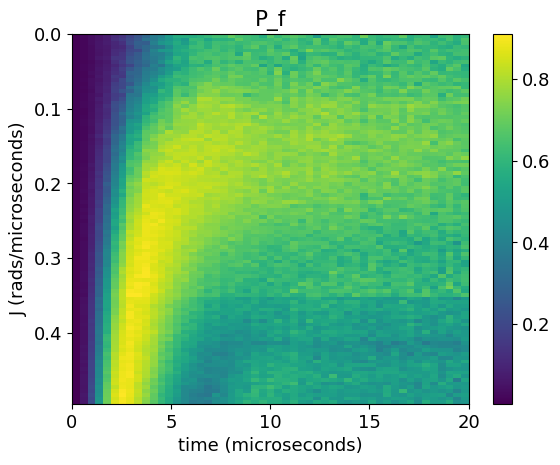

In [16]:
num_steps = 51
sweep_time = 20000
J_start = 0#J_list[0]
J_stop =.495# J_list[-1]
J_steps =100# len(J_list)
J_vals = np.linspace(J_start, J_stop, J_steps)
p_f = np.zeros((J_steps, num_steps))
for i in range(J_steps):
    p_f[i] = probability_dataframes[J_vals[i]]["P_f"] / ( probability_dataframes[J_vals[i]]["P_f"]+ probability_dataframes[J_vals[i]]["P_e"])
plt.imshow(p_f, extent=[0, sweep_time / 1000, J_stop, J_start], aspect="auto")
plt.colorbar()
plt.ylabel("J (rads/microseconds)")
plt.xlabel("time (microseconds)")
plt.title("P_f")
plt.show()

In [13]:
J_stop

1.0